In [1]:
# Filtering out the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import the required Libraries.
import functools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## PROBLEM STATEMENT
A consumer finance company specialises in lending various types of loans to urban customers. The company finds it hard to give loans to the people due to their insufficient or non-existent credit history. Some consumers use it as their advantage by becoming a defaulter. 
When the company receives a loan application, it has to decide for loan approval **based on the applicant’s profile**. Two types of risks are associated with the bank’s decision:
- If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company
- If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company.

**DATA PROVIDED** contains the information about the loan application at the time of applying for the loan. It contains two types of scenarios:
- The client with payment difficulties: Payment was delayed for more than X days on at least one of the first Y instalments of the loan
- All other cases: Payment is paid on time.

**WHAT IS REQUIRED?** **Identify patterns** present in the data which indicate if a client has difficulty paying their installments. Identify the driving factors behind loan default, i.e. the variables which are strong indicators of default. 

**HOW DOES THIS HELP?**
The company can utilise this knowledge for its portfolio and risk assessment. This will help the company
- To take actions (such as denying the loan, reducing the amount of loan etc.) against risky applicants
- Not to reject applicants capable of repaying the loan.


## DEFINITIONS
Some utility functions that are used in the notebook

### General mathematical Functions

In [3]:
def percent(val, total):
    return round(100 * val/total, 2)

def getIQR(df, col):
    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    return Q3 - Q1

def getMinScore(df, col):
    Q1 = df[col].quantile(0.75)
    iqr = getIQR(df, col)
    return Q1 - 1.5 * iqr

def getMaxScore(df, col):
    Q3 = df[col].quantile(0.75)
    iqr = getIQR(df, col)
    return Q3 + 1.5 * iqr

### General Dataframe functions

In [4]:
def listColumsWithMissingData(df):
    naCols = len(df.columns[df.isna().any()])
    print(f"Columns with missing data: {naCols} {percent(naCols, len(df.columns))}%")
    [print(f"{col:30}  {df[col].isna().sum(): 7d} {percent(df[col].isna().sum(),df.shape[0])}%") for col in df.columns if df[col].isna().any() ]

def listColumsWithInvalidData(df):
    COLS = df.columns.tolist()
    TOTAL = df.shape[0]
    print(f"Columns with invalid data:", end="")
    invalidColCount = 0
    invalidColDetails = ""
    for col in COLS:
        cnt = df[df[col].isin(['XNA','XAP'])].shape[0]
        if cnt > 0:
            invalidColCount += 1
            invalidColDetails += f"{col}: {cnt} {percent(cnt, TOTAL)}%\n"
    print(invalidColCount)
    print(invalidColDetails)

def getGeneralInfo(df):
    print("Shape:",df.shape);print()
    print("Columns:", df.columns.tolist());print()
    print(df.info());print()
    describeWoIdTarget(df);print()
    getCategoricalValues(df);print()
    listColumsWithMissingData(df);print()
    listColumsWithInvalidData(df)

def getCategoryDf(df, category):
    return df[category + ['SK_ID_CURR', 'TARGET']]

def getBasicDf(df):
    return df[list(set(df.columns.tolist() ) - set(['SK_ID_CURR', 'TARGET']))]
    
def getColumnsStartingWith(df, prefix):
    prefixlen = len(prefix)
    return list(filter(lambda x: x[:prefixlen] == prefix, df.columns.tolist()))

def describeWoIdTarget(df):
    print("Numerical values - describe:")
    colsWoIdTarget = list(set(df.columns.tolist() ) - set(['SK_ID_CURR', 'TARGET']))
    df = df[colsWoIdTarget]
    print(df.describe())
    
def dropColumns(df, coldesc, cols):
    print(f"Drop {coldesc} {len(cols)} columns: Shape - before {df.shape}", end=" ")
    df.drop(columns = cols, inplace=True)
    print(f"Shape - after {df.shape}")

def getTop10Correlations(df):
    c = df.corr().abs()
    s = c.unstack()
    cldf = s.sort_values(kind="quicksort", ascending=False).to_frame().reset_index()
    cldf = cldf[cldf['level_0']!=cldf['level_1']]
    cldf = cldf.rename(columns={'level_0':'Variable1', 'level_1':'Variable2', 0:'CORR'})
    cldf['vars'] = cldf['Variable1'] + cldf['Variable2']
    cldf['vars'] = cldf['vars'].apply(lambda x: "".join(sorted(x)))
    cldf['CORR'] = round(cldf['CORR'], 2)
    cldf = cldf.drop_duplicates('vars')[['Variable1', 'Variable2', 'CORR']][0:10]
    return cldf

### Dataframe manipulation functions 

In [5]:
def getCategoricalValues(df):
    cat_columns = df.select_dtypes(include=['object']).columns.tolist()
    cat_columns.sort()
    print(f"Columns with categorical values {len(cat_columns)} --> {cat_columns}")
    for col in cat_columns:
        count_values = df[col].unique().shape[0]
        print(f"{col:27} : [{count_values:2}] --> {sorted((df[col].unique().tolist())) if np.NaN not in df[col].unique().tolist() else (df[col].unique().tolist())}")
        
def getNumCategoricalValues(df, ncat_columns):
    ncat_columns.sort()
    print(f"Columns with categorical values {len(ncat_columns)}")
    for col in ncat_columns:
        count_values = df[col].unique().shape[0]
        if count_values > 30:
            print(f"{col:26} : [{count_values:4}] --> {sorted(df[col].unique().tolist()[:10])}...{sorted(df[col].unique().tolist()[-10:])}") 
        else:
            print(f"{col:26} : [{count_values:4}] --> {sorted(df[col].unique().tolist())}") 

def makeDFForTarget(df, col, taretVal):
    df_ = df[df['TARGET']==taretVal][[col,'TARGET']]
    cnt = df_.shape[0]
    df_ = groupByAndCount(df_, col, skipPercent=False)
    df_.rename(columns={'Count':f'Target={taretVal}'},inplace=True)
    #print(df_)
    return df_, cnt


def makeDFForTargets(df, col):
    df_1, cnt_1 = makeDFForTarget(df, col, 1)
    df_0, cnt_0 = makeDFForTarget(df, col, 0)
    print(cnt_1, cnt_0)

    df_ = df_0.merge(df_1, how='left',on=col)
    print(df_)
    df_.set_index(col, inplace=True)
    return df_


def groupByAndCount(df, col, sort = True, skipPercent=True):
    total_rows = df.shape[0]
    df_ = df.groupby(by=col).agg({col:"count"})
    df_.rename(columns={col:'Count'}, inplace=True)
    df_.reset_index(inplace=True)
    if sort == True: df_.sort_values(by='Count', ascending=False, inplace=True)
    if not skipPercent:
        df_['%'] = round((df_['Count']/total_rows)*100,2)
    return df_
    
def groupPerTarget(df, col):
    df_1 = df[df['TARGET']==1][[col,'TARGET']]
    cnt_1 = df_1.shape[0]
    df_1 = groupByAndCount(df_1, col, sort = False)
    df_1.rename(columns={'Count':'Target=1'},inplace=True)
    #print(df_1)

    df_0 = df[df['TARGET']==0][[ col,'TARGET']]
    cnt_0 = df_0.shape[0]
    df_0 = groupByAndCount(df_0, col, sort = False)
    df_0.rename(columns={'Count':'Target=0'},inplace=True)
    #print(df_0)


    df_ = df_0.merge(df_1, how='left',on=col)
    if df_.isna().sum().sum() > 0:
        df_.fillna(0, inplace=True)
    df_['Total'] = df_['Target=0'] + df_['Target=1']
    df_['Target=0%'] = percent(df_['Target=0'], df_['Total']) 
    df_['Target=1%'] = percent(df_['Target=1'], df_['Total'])
    df_.set_index(col, inplace=True)

    #df_[['Total', 'Target=1', 'Target=0']].astype('int32')
    df_= df_[['Total', 'Target=1', 'Target=0', 'Target=1%', 'Target=0%' ]]

    print(f"df_1: {cnt_1}, df_0: {cnt_0}")
    print(df_)
    
    return df_

def groupPerTargetLimited(df, col):
    df_1 = df[df['TARGET']==1][[col,'TARGET']]
    cnt_1 = df_1.shape[0]
    df_1 = groupByAndCount(df_1, col, sort = False)
    df_1.rename(columns={'Count':'Target=1'},inplace=True)
    #print(df_1)

    df_0 = df[df['TARGET']==0][[ col,'TARGET']]
    cnt_0 = df_0.shape[0]
    df_0 = groupByAndCount(df_0, col, sort = False)
    df_0.rename(columns={'Count':'Target=0'},inplace=True)
    #print(df_0)


    df_ = df_0.merge(df_1, how='left',on=col)
    df_['Total'] = df_['Target=0'] + df_['Target=1']
    df_['Target=0%'] = percent(df_['Target=0'], df_['Total']) 
    df_['Target=1%'] = percent(df_['Target=1'], df_['Total'])
    df_.set_index(col, inplace=True)

    #df_[['Total', 'Target=1', 'Target=0']].astype('int32')
    df_= df_[['Total', 'Target=1', 'Target=0', 'Target=1%', 'Target=0%' ]]

    df_.sort_values(by='Target=1%', ascending=False, inplace=True)
    df_ = df_[df_['Total'] > 1000]

    #print(f"df_1: {cnt_1}, df_0: {cnt_0}")
    #print(df_)
    
    return df_

# -----
def groupByTargetAndCount(df, value, sort = True, skipPercent=True):
    total_rows = df.shape[0]
    df_ = df.groupby(by='TARGET').agg({'TARGET':"count"})
    df_.rename(columns={'TARGET': f'{value}_Count'}, inplace=True)
    df_.reset_index(inplace=True)
    if sort == True: df_.sort_values(by=f'{value}_Count', ascending=False, inplace=True)
    if not skipPercent:
        df_[f'{value}_%'] = round((df_[f'{value}_Count']/total_rows)*100,2)
    return df_

def makeDFForTarget1(df, col, value):
    df_ = df[df[col]==value][[col,'TARGET']]
    #print(df_)
    cnt = df_.shape[0]
    df_ = groupByTargetAndCount(df_, value, skipPercent=False)
    return df_, cnt


def makeDFForTargets1(df, col):
    df_1, cnt_1 = makeDFForTarget1(df_ca, col, 'N')
    df_0, cnt_0 = makeDFForTarget1(df_ca, col, 'Y')
    print(cnt_1, cnt_0)
    df_ = df_0.merge(df_1, how='left',on='TARGET')
    print(df_)
    df_.set_index('TARGET', inplace=True)
    df_ = df_.transpose()
    df_ = df_.loc[['Y_%', 'N_%']]
    return df_
# ---

### Visualization functions

In [6]:

def plotBar(df, title, w=10, h=10, logy=False):
    plt.figure(figsize=(w, h), dpi=80)
    ax = df.plot.bar(logy=logy) 
    # Annotate
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    ax.set_title(title)
    plt.show()

def annotate(ax):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

def plotScatter(df, col1, col2, title, pos=1, log=False):
    plt.subplot(1, 2, pos)
    ax = df.plot.scatter(col1, col2,figsize=(10, 6))
    if log == True: ax.set_xscale('log')
    ax.set_title(title)
    plt.show()

# TODO: annotation - add %
def plotTargetWiseBarPlots(df, col, title, labels=[], figsize=(10, 6)):
    df_ = groupPerTarget(df, col)

    plt.figure(dpi=80) #figsize=(20, 6),dpi=80
    plt.subplot(1, 2, 1)

    ax = df_[['Target=0','Target=1']].plot.bar(ax=plt.gca(), logy=True, figsize=figsize, rot=90)
    annotate(ax)
    if labels: ax.set_xticklabels(labels=labels, rotation=45)
    ax.set_title(f"{title} Vs Target - Absolute values")

    plt.subplot(1, 2, 2)
    ax = df_[['Target=0%','Target=1%']].plot.bar(ax=plt.gca(), logy=True, figsize=figsize)
    annotate(ax)
    if labels: ax.set_xticklabels(labels=labels, rotation=45)
    ax.set_title(f"{title} Vs Target - %age values")

    plt.show()

def compareLimited(df, col, title, labels=[], figsize=(10, 6)):
    df_ = groupPerTargetLimited(df, col)

    plt.figure(dpi=80) #figsize=(20, 6),dpi=80
    plt.subplot(1, 2, 1)

    ax = df_[['Target=0','Target=1']].plot.bar(ax=plt.gca(), logy=True, figsize=figsize, rot=90)
    annotate(ax)
    if labels: ax.set_xticklabels(labels=labels, rotation=45)
    ax.set_title(f"{title} Vs Target - Absolute values")

    plt.subplot(1, 2, 2)
    ax = df_[['Target=0%','Target=1%']].plot.bar(ax=plt.gca(), logy=True, figsize=figsize)
    annotate(ax)
    if labels: ax.set_xticklabels(labels=labels, rotation=45)
    ax.set_title(f"{title} Vs Target - %age values")

## **INSPECT & PREPARE** THE DATA

### Read & **INSPECT** the data

In [7]:
df_ca_orig = pd.read_csv("data/application_data.csv")
df_ca_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


- There are 307511 rows & 122 columns. Since the number of columns is high, it would be better to **categorise the columns into sub-groups for further analysis**.
- Few columns have missing data. These columns have to inspected further.
- SK_ID_CURR is client identifier. This column should be checked for duplicates.
- TARGET is the output variable of categorical type
    - 1 - difficulties in paying the loan
    - 0 - no difficulties in paying the loan

TODO:
- Bin REGION_POPULATION_RELATIVE 

### **CATEGORIZE** the columns convenient analysis

In [8]:
CA_DEMOGRAPHIC_PERSONAL_COLS = [ 'CODE_GENDER', 'DAYS_BIRTH', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'NAME_FAMILY_STATUS', 
                            'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']
CA_DEMOGRAPHIC_PROFESSIONAL_COLS = [ 'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE',  'ORGANIZATION_TYPE'] #'OCCUPATION_TYPE',

CA_CHARACTER_COLS = getColumnsStartingWith(df_ca_orig, 'AMT_REQ_CREDIT_BUREAU_')
CA_SOCIAL_CIRCLE_COLS = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']

CA_AMOUNT_COLS = ['AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 'AMT_ANNUITY']

CA_CAPACITY_COLS = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'DAYS_EMPLOYED']

CA_APPLICATION_COLS = ['NAME_TYPE_SUITE','DAYS_REGISTRATION','DAYS_ID_PUBLISH',
        'FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL',
        'WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START',
        'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY',
        'FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8',
        'FLAG_DOCUMENT_9','FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15',
        'FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']

CA_FLAG_DOCUMENT_COLS = getColumnsStartingWith(df_ca_orig, 'FLAG_DOCUMENT_')
CA_BUILDING_COLS = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
    'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
    'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE','COMMONAREA_MODE','ELEVATORS_MODE','ENTRANCES_MODE',
    'FLOORSMAX_MODE','FLOORSMIN_MODE','LANDAREA_MODE','LIVINGAPARTMENTS_MODE','LIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE','NONLIVINGAREA_MODE','APARTMENTS_MEDI',
    'BASEMENTAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI','YEARS_BUILD_MEDI','COMMONAREA_MEDI','ELEVATORS_MEDI','ENTRANCES_MEDI','FLOORSMAX_MEDI','FLOORSMIN_MEDI',
    'LANDAREA_MEDI','LIVINGAPARTMENTS_MEDI','LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAREA_MEDI','FONDKAPREMONT_MODE','HOUSETYPE_MODE',
    'TOTALAREA_MODE','WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE']

# Description of the columns/variables is not clear
CA_EXT_SOURCE_COLS = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

CA_CLIENT_COLS = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH', 'DAYS_EMPLOYED', ]

### Inspect the dataset for **IMBALANCE**

In [9]:
# Inspect the output variable
groupByAndCount(df_ca_orig, 'TARGET', skipPercent=False)

TARGET   Count      %
0       0  282686  91.93
1       1   24825   8.07

The dataset is imbalanced. Data wrt cients with TARGET=1 is much lesser (8%) than compared to the data with TARGET=0 (92%). During analysis this needs to be taken into consideration. 

There is a data imbalance wrt to the TARGET variable in the ratio 92% (0) and 8% (1). This means the data corresponding to the **clients with payment difficulties is very less compared to the clients without payment difficulties**. To avoid this imbalance bias the analysis (towards to Target=0 case), the comparisons of various variables wrt Target categories were made using percentages.

### Inspect the dataset for **MISSING** values

In [10]:
print("Current Application - Columns with missing vaules")
listColumsWithMissingData(df_ca_orig)

Current Application - Columns with missing vaules
Columns with missing data: 67 54.92%
AMT_ANNUITY                          12 0.0%
AMT_GOODS_PRICE                     278 0.09%
NAME_TYPE_SUITE                    1292 0.42%
OWN_CAR_AGE                      202929 65.99%
OCCUPATION_TYPE                   96391 31.35%
CNT_FAM_MEMBERS                       2 0.0%
EXT_SOURCE_1                     173378 56.38%
EXT_SOURCE_2                        660 0.21%
EXT_SOURCE_3                      60965 19.83%
APARTMENTS_AVG                   156061 50.75%
BASEMENTAREA_AVG                 179943 58.52%
YEARS_BEGINEXPLUATATION_AVG      150007 48.78%
YEARS_BUILD_AVG                  204488 66.5%
COMMONAREA_AVG                   214865 69.87%
ELEVATORS_AVG                    163891 53.3%
ENTRANCES_AVG                    154828 50.35%
FLOORSMAX_AVG                    153020 49.76%
FLOORSMIN_AVG                    208642 67.85%
LANDAREA_AVG                     182590 59.38%
LIVINGAPARTMENTS_AVG         

Remove following columns
| Ccolumns | Reason | 
|---|---|
| Building data columns | More than 50% data missing |
| OWN_CAR_AGE | More than 50% data missing |
| EXT_SOURCE_* columns | Meaning of these columns is not clear |
| DAYS_LAST_PHONE_CHANGE | Not using this column for analysis |
| NAME_TYPE_SUITE | |
- There are no rows with TARGET variable not filled. So nothing to drop.

In [11]:
dropColumns(df_ca_orig, "Building data", CA_BUILDING_COLS)
dropColumns(df_ca_orig, "OWN_CAR_AGE", 'OWN_CAR_AGE')
dropColumns(df_ca_orig, "EXT_SOURCE_*", CA_EXT_SOURCE_COLS)
dropColumns(df_ca_orig, "DAYS_LAST_PHONE_CHANGE", 'DAYS_LAST_PHONE_CHANGE')
dropColumns(df_ca_orig, "OCCUPATION_TYPE", 'OCCUPATION_TYPE')

Drop Building data 47 columns: Shape - before (307511, 122) Shape - after (307511, 75)
Drop OWN_CAR_AGE 11 columns: Shape - before (307511, 75) Shape - after (307511, 74)
Drop EXT_SOURCE_* 3 columns: Shape - before (307511, 74) Shape - after (307511, 71)
Drop DAYS_LAST_PHONE_CHANGE 22 columns: Shape - before (307511, 71) Shape - after (307511, 70)
Drop OCCUPATION_TYPE 15 columns: Shape - before (307511, 70) Shape - after (307511, 69)


In [12]:
print("Current Application - Columns with missing vaules")
listColumsWithMissingData(df_ca_orig)

Current Application - Columns with missing vaules
Columns with missing data: 14 20.29%
AMT_ANNUITY                          12 0.0%
AMT_GOODS_PRICE                     278 0.09%
NAME_TYPE_SUITE                    1292 0.42%
CNT_FAM_MEMBERS                       2 0.0%
OBS_30_CNT_SOCIAL_CIRCLE           1021 0.33%
DEF_30_CNT_SOCIAL_CIRCLE           1021 0.33%
OBS_60_CNT_SOCIAL_CIRCLE           1021 0.33%
DEF_60_CNT_SOCIAL_CIRCLE           1021 0.33%
AMT_REQ_CREDIT_BUREAU_HOUR        41519 13.5%
AMT_REQ_CREDIT_BUREAU_DAY         41519 13.5%
AMT_REQ_CREDIT_BUREAU_WEEK        41519 13.5%
AMT_REQ_CREDIT_BUREAU_MON         41519 13.5%
AMT_REQ_CREDIT_BUREAU_QRT         41519 13.5%
AMT_REQ_CREDIT_BUREAU_YEAR        41519 13.5%


At this point, there are 70 columns left out of which 15 columns still have missing data. **Imputation** for the columns will be done in the individual sections corresponding to each category

### Inspect for **DUPLICATE** rows

In [13]:
# Check if there are duplicate rows - with the same SK_ID_CURR
df_ca_orig[df_ca_orig['SK_ID_CURR'].duplicated()==True]

Empty DataFrame
Columns: [SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, FLAG_DOCUMENT_6, FLAG_DOCUMENT_7, FLAG_DOCUMENT_8, FLAG_DOCUMENT_9, FLAG_DOCUMENT_10, FLAG_DOCUMENT_11, FLAG_DOCUMENT_12, FLAG_DOCUMENT_13, FLAG_DOCUMENT_14, FLAG_DOCUMENT_15, FLAG_DOCUMENT_16, FLAG_DOCUMENT_17, FLAG_DOCUMENT_18, FLAG_DOCUMENT_19, FLAG_DOCUMENT_20, FLAG_DOCUMENT_21, AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY, AMT_REQ_CREDIT_BUREAU_WEEK, AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_QRT, AMT_REQ_CREDIT_BUREAU_YEAR]
Index: []

[0 rows x 69 columns]

There are no duplicate rows i.e. with the same SK_ID_CURR, so no handling required.

## **STRATEGY FOR ANALYSIS**
The variables/columns (excluding SK_ID_CURR the client id and TARGET variable) are categorised into following categories. Further analysis is done for each category
1. **Demographic - Personal**: Applicant's personal information
2. **Demographic - Professional**: Applicant's professional information
3. **Character**: 
    - Applicant's credit history - a borrower's reputation or track record for repaying debts. 
    - Calls to Credit Bureau
    - Defaulter's in social circle
4. **Capacity**: 
    - Applicant's debt-to-income ratio measures the borrower's ability to repay a loan by comparing income against recurring debts.Borrower's total monthly debt payments and dividing that by the borrower's gross monthly income.an applicant's DTI to be around 35% or less. 
    - The length of time an applicant has been employed at their current job and future job stability. 
    - Income, Credit, Goods
5. **Capital**: Amount of money an applicant has.
    - Car, Realty
6. **Application**: Information provided in the application

_Note: The Character, Capacity & Capital categorisation is based on the [Five C's of Credit](https://www.investopedia.com/terms/f/five-c-credit.asp) system that is used by lenders to gauge the creditworthiness of potential borrowers._

For each category, following analysis is to be done:
- Inspect dataset
- Inspect for & handle missing & invalid values
- Univariate analysis
- Bivariate analysis
- Observations/Insights

Finally, correlation analysis is done on all the variables

In [14]:
df_ca = df_ca_orig.copy(deep=True)
print(df_ca.shape)

(307511, 69)


In [15]:
df_ca['NAME_CONTRACT_TYPE']
#REGION_POPULATION_RELATIVE

0              Cash loans
1              Cash loans
2         Revolving loans
3              Cash loans
4              Cash loans
               ...       
307506         Cash loans
307507         Cash loans
307508         Cash loans
307509         Cash loans
307510         Cash loans
Name: NAME_CONTRACT_TYPE, Length: 307511, dtype: object

df_1: 24825, df_0: 282686
                     Total  Target=1  Target=0  Target=1%  Target=0%
NAME_CONTRACT_TYPE                                                  
Cash loans          278232     23221    255011       8.35      91.65
Revolving loans      29279      1604     27675       5.48      94.52


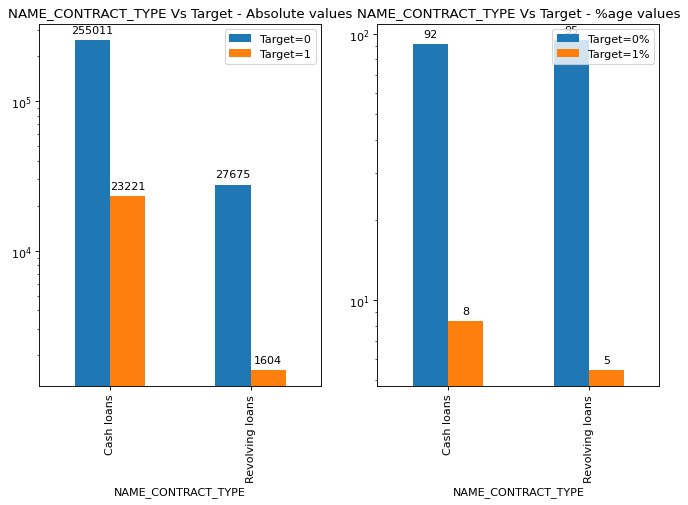

In [16]:
plotTargetWiseBarPlots(df_ca,'NAME_CONTRACT_TYPE','NAME_CONTRACT_TYPE')

## 1. ANALYSIS: **Demographic - Personal**
Applicant's personal information

### Inspect

In [17]:
df_ca_demo_per = getCategoryDf(df_ca, CA_DEMOGRAPHIC_PERSONAL_COLS)
getGeneralInfo(df_ca_demo_per)

Shape: (307511, 11)

Columns: ['CODE_GENDER', 'DAYS_BIRTH', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'SK_ID_CURR', 'TARGET']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   CODE_GENDER                  307511 non-null  object 
 1   DAYS_BIRTH                   307511 non-null  int64  
 2   CNT_CHILDREN                 307511 non-null  int64  
 3   CNT_FAM_MEMBERS              307509 non-null  float64
 4   NAME_FAMILY_STATUS           307511 non-null  object 
 5   NAME_HOUSING_TYPE            307511 non-null  object 
 6   REGION_POPULATION_RELATIVE   307511 non-null  float64
 7   REGION_RATING_CLIENT         307511 non-null  int64  
 8   REGION_RATING_CLIENT_W_CITY  307511 non-null  

In [18]:
print(df_ca_demo_per['REGION_RATING_CLIENT'].value_counts())
print(df_ca_demo_per['REGION_RATING_CLIENT_W_CITY'].value_counts())

2    226984
3     48330
1     32197
Name: REGION_RATING_CLIENT, dtype: int64
2    229484
3     43860
1     34167
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64


REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY seem to contain similar values. Let's inspect

In [19]:
print("REGION_RATING_CLIENT != REGION_RATING_CLIENT_W_CITY =", df_ca_demo_per.loc[df_ca_demo_per['REGION_RATING_CLIENT'] != df_ca_demo_per['REGION_RATING_CLIENT_W_CITY']].shape[0])
print("REGION_RATING_CLIENT  > REGION_RATING_CLIENT_W_CITY =", df_ca_demo_per.loc[df_ca_demo_per['REGION_RATING_CLIENT'] > df_ca_demo_per['REGION_RATING_CLIENT_W_CITY']].shape[0])
print("REGION_RATING_CLIENT  < REGION_RATING_CLIENT_W_CITY =", df_ca_demo_per.loc[df_ca_demo_per['REGION_RATING_CLIENT'] < df_ca_demo_per['REGION_RATING_CLIENT_W_CITY']].shape[0])

REGION_RATING_CLIENT != REGION_RATING_CLIENT_W_CITY = 5718
REGION_RATING_CLIENT  > REGION_RATING_CLIENT_W_CITY = 5718
REGION_RATING_CLIENT  < REGION_RATING_CLIENT_W_CITY = 0


- Both REGION_RATING_CLIENT and REGION_RATING_CLIENT_W_CITY indicate a similar trait. So only one can be considered. REGION_RATING_CLIENT_W_CITY ratings >= REGION_RATING_CLIENT. So let's drop REGION_RATING_CLIENT and go only with REGION_RATING_CLIENT_W_CITY
- REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY are numerical discrete type. But these should be categorical.

In [20]:
df_ca_demo_per['REGION_RATING_CLIENT'] = df_ca_demo_per['REGION_RATING_CLIENT'].apply(lambda x: str(x))
df_ca_demo_per['REGION_RATING_CLIENT_W_CITY'] = df_ca_demo_per['REGION_RATING_CLIENT'].apply(lambda x: str(x))
#print('REGION_RATING_CLIENT_W_CITY:',df_ca_demo_per['REGION_RATING_CLIENT_W_CITY'].unique().tolist())

In [21]:
getCategoricalValues(df_ca_demo_per)

Columns with categorical values 5 --> ['CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']
CODE_GENDER                 : [ 3] --> ['F', 'M', 'XNA']
NAME_FAMILY_STATUS          : [ 6] --> ['Civil marriage', 'Married', 'Separated', 'Single / not married', 'Unknown', 'Widow']
NAME_HOUSING_TYPE           : [ 6] --> ['Co-op apartment', 'House / apartment', 'Municipal apartment', 'Office apartment', 'Rented apartment', 'With parents']
REGION_RATING_CLIENT        : [ 3] --> ['1', '2', '3']
REGION_RATING_CLIENT_W_CITY : [ 3] --> ['1', '2', '3']


### Handle Missing & Invalid values
| COLUMN(S) | Data type | Missing & Invalid value Strategy | 
|---|---|---|
| CODE_GENDER | Categorical Unordered | 4 rows with XNA. Remove these rows | 
| DAYS_BIRTH | Numerical continuous | DAYS_BIRTH is a relative (-ve) value (in days) to the application. Convert it to AGE adn then bin the values. | 
| CNT_CHILDREN | Numerical discrete | _No missing/invalid values_ | 
| CNT_FAM_MEMBERS | Numerical discrete | 2 items are missing. Impute this with the median value (typical value) | 
| NAME_FAMILY_STATUS | Categorical Unordered | 2 rows have 'Unknown'. Remove these rows | 
| HOUSING_TYPE | Categorical Unordered | _No missing/invalid values_ | 
| REGION_POPULATION_RELATIVE | Numerical continuous | _No missing/invalid values_ |
| REGION_RATING_CLIENT | Numerical continuous --> Categorical Ordered   | As REGION_RATING_CLIENT & REGION_RATING_CLIENT_W_CITY have similar data, drop the column REGION_RATING_CLIENT | 
| REGION_RATING_CLIENT_W_CITY | Numerical continuous --> Categorical Ordered  | _No missing/invalid values_ | 

In [22]:
df_ca_demo_per['CNT_FAM_MEMBERS'] = df_ca_demo_per['CNT_FAM_MEMBERS'].fillna(df_ca_demo_per['CNT_FAM_MEMBERS'].median())
listColumsWithMissingData(df_ca_demo_per)

Columns with missing data: 0 0.0%


In [23]:
# 'CODE_GENDER' has 4 rows with XNA. Remove these rows
df_ca_demo_per = df_ca_demo_per[df_ca_demo_per['CODE_GENDER']!='XNA']

# 'NAME_FAMILY_STATUS' has 2 rows with Unknown. Remove these rows
df_ca_demo_per = df_ca_demo_per[df_ca_demo_per['NAME_FAMILY_STATUS']!='Unknown']

getCategoricalValues(df_ca_demo_per)

Columns with categorical values 5 --> ['CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']
CODE_GENDER                 : [ 2] --> ['F', 'M']
NAME_FAMILY_STATUS          : [ 5] --> ['Civil marriage', 'Married', 'Separated', 'Single / not married', 'Widow']
NAME_HOUSING_TYPE           : [ 6] --> ['Co-op apartment', 'House / apartment', 'Municipal apartment', 'Office apartment', 'Rented apartment', 'With parents']
REGION_RATING_CLIENT        : [ 3] --> ['1', '2', '3']
REGION_RATING_CLIENT_W_CITY : [ 3] --> ['1', '2', '3']


In [24]:
# DAYS_BIRTH is a realative (-ve) value (in days) to the application. Convert it to age.
df_ca_demo_per['AGE'] = (df_ca_demo_per['DAYS_BIRTH']/365)*(-1)

In [25]:
# Drop the column REGION_RATING_CLIENT
dropColumns(df_ca_demo_per, "REGION_RATING_CLIENT", ['REGION_RATING_CLIENT'])

Drop REGION_RATING_CLIENT 1 columns: Shape - before (307505, 12) Shape - after (307505, 11)


### Analysis

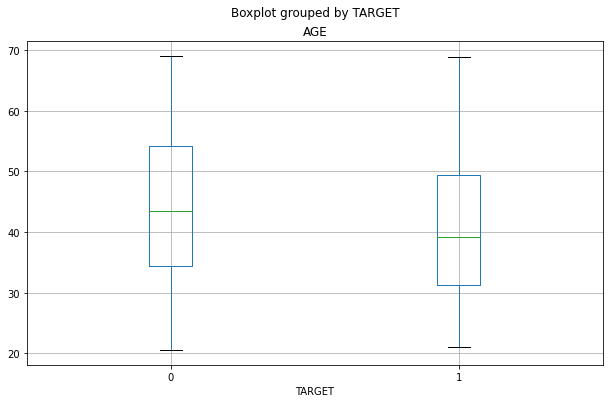

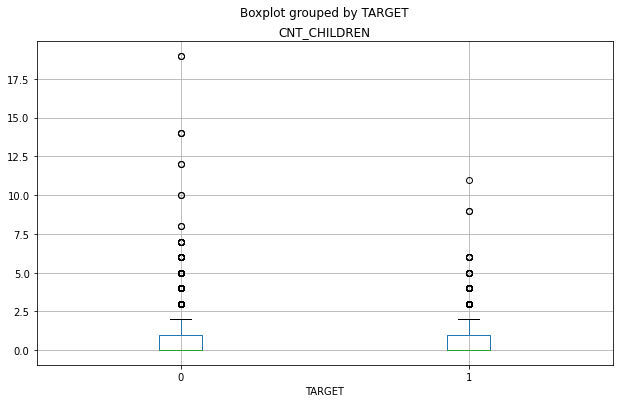

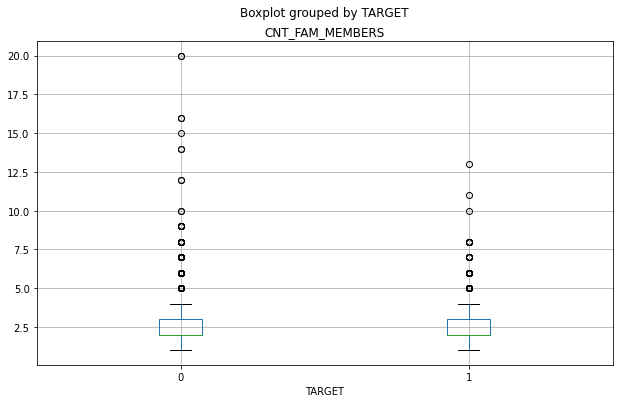

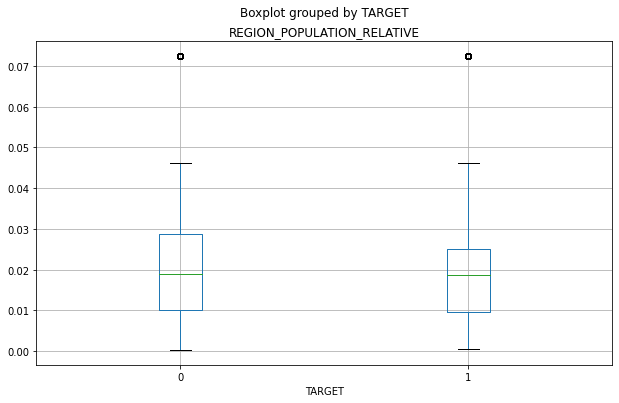

In [26]:
# Check for outliers
for col in ['AGE', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'REGION_POPULATION_RELATIVE']: 
    df_ca_demo_per.boxplot(column=col, by='TARGET', figsize = (10, 6))

Outliers (beyond the lower and upper fences) exist for 
- CNT_CHIDLREN : > 2.5 till 19
- CNT_FAM_MEMBERS : > 5 till 20
- REGION_POPULATION_RELATIVE : 1 area is heavily populated compared to the rest

In [27]:
# It would make sense to group the ages into more maangeable groups
df_ca_demo_per['AGE'] = pd.cut(df_ca_demo_per['AGE'], [20, 30, 40, 50, 60, 70], labels=['20-30', '30-40', '40-50', '50-60', '60-70'])

df_1: 24825, df_0: 282680
              Total  Target=1  Target=0  Target=1%  Target=0%
CODE_GENDER                                                  
F            202447     14170    188277       7.00      93.00
M            105058     10655     94403      10.14      89.86


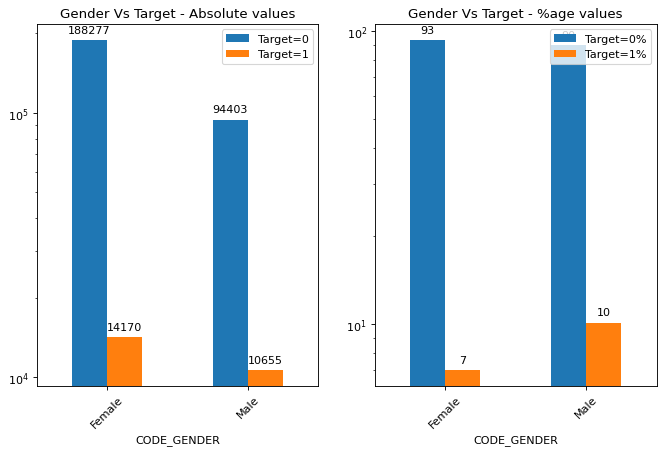

df_1: 24825, df_0: 282680
       Total  Target=1  Target=0  Target=1%  Target=0%
AGE                                                   
20-30  45019      5158     39861      11.46      88.54
30-40  82305      7888     74417       9.58      90.42
40-50  76541      5856     70685       7.65      92.35
50-60  68061      4172     63889       6.13      93.87
60-70  35579      1751     33828       4.92      95.08


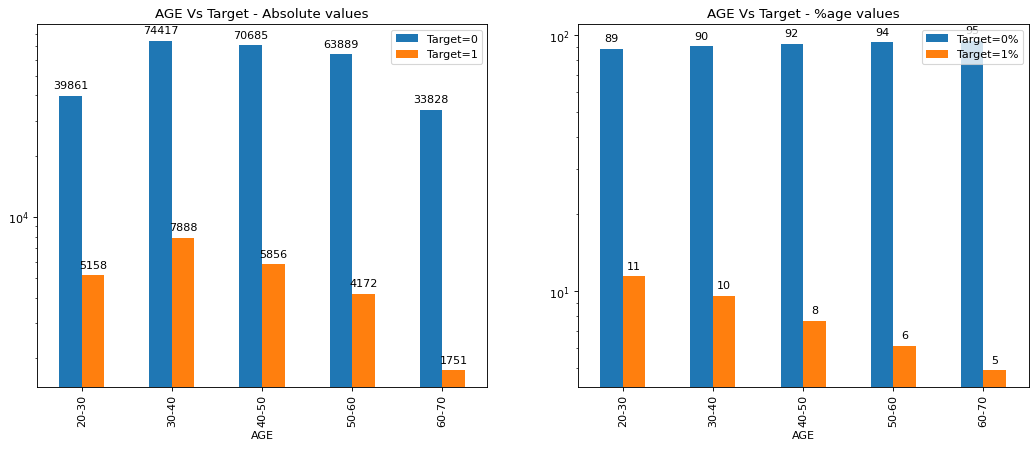

df_1: 24825, df_0: 282680
                 Total  Target=1  Target=0  Target=1%  Target=0%
CNT_CHILDREN                                                    
0             215367.0   16609.0    198758       7.71      92.29
1              61118.0    5454.0     55664       8.92      91.08
2              26748.0    2333.0     24415       8.72      91.28
3               3717.0     358.0      3359       9.63      90.37
4                429.0      55.0       374      12.82      87.18
5                 84.0       7.0        77       8.33      91.67
6                 21.0       6.0        15      28.57      71.43
7                  7.0       0.0         7       0.00     100.00
8                  2.0       0.0         2       0.00     100.00
10                 2.0       0.0         2       0.00     100.00
12                 2.0       0.0         2       0.00     100.00
14                 3.0       0.0         3       0.00     100.00
19                 2.0       0.0         2       0.00     100.00

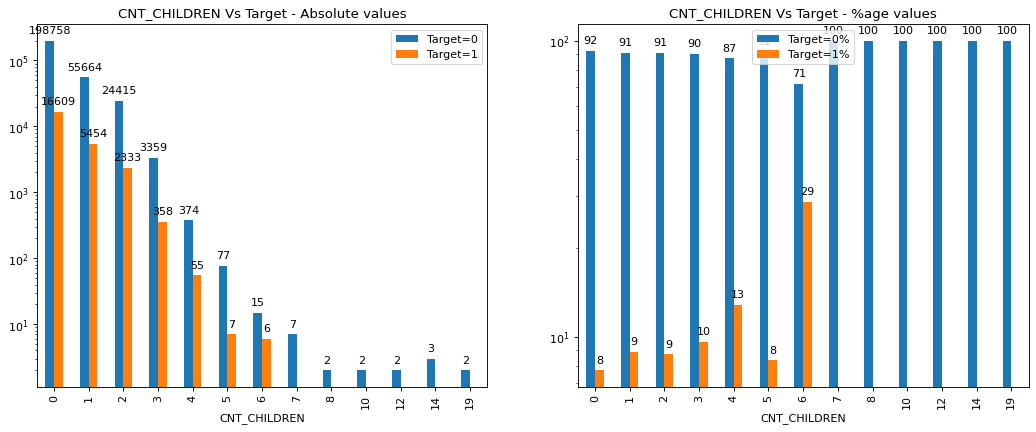

df_1: 24825, df_0: 282680
                    Total  Target=1  Target=0  Target=1%  Target=0%
CNT_FAM_MEMBERS                                                    
1.0               67847.0    5675.0     62172       8.36      91.64
2.0              158355.0   12009.0    146346       7.58      92.42
3.0               52600.0    4608.0     47992       8.76      91.24
4.0               24696.0    2136.0     22560       8.65      91.35
5.0                3478.0     327.0      3151       9.40      90.60
6.0                 408.0      55.0       353      13.48      86.52
7.0                  81.0       6.0        75       7.41      92.59
8.0                  20.0       6.0        14      30.00      70.00
9.0                   6.0       0.0         6       0.00     100.00
10.0                  3.0       1.0         2      33.33      66.67
12.0                  2.0       0.0         2       0.00     100.00
14.0                  2.0       0.0         2       0.00     100.00
15.0                  

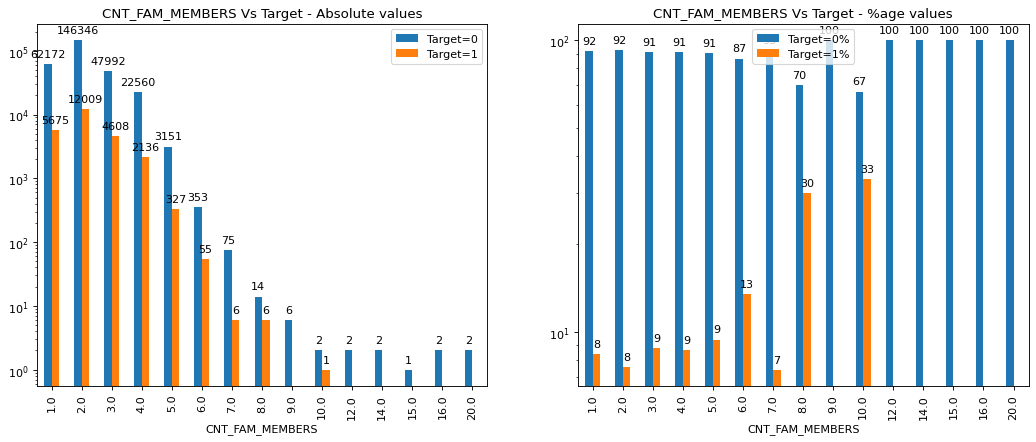

df_1: 24825, df_0: 282680
                       Total  Target=1  Target=0  Target=1%  Target=0%
NAME_FAMILY_STATUS                                                    
Civil marriage         29774      2961     26813       9.94      90.06
Married               196429     14850    181579       7.56      92.44
Separated              19770      1620     18150       8.19      91.81
Single / not married   45444      4457     40987       9.81      90.19
Widow                  16088       937     15151       5.82      94.18


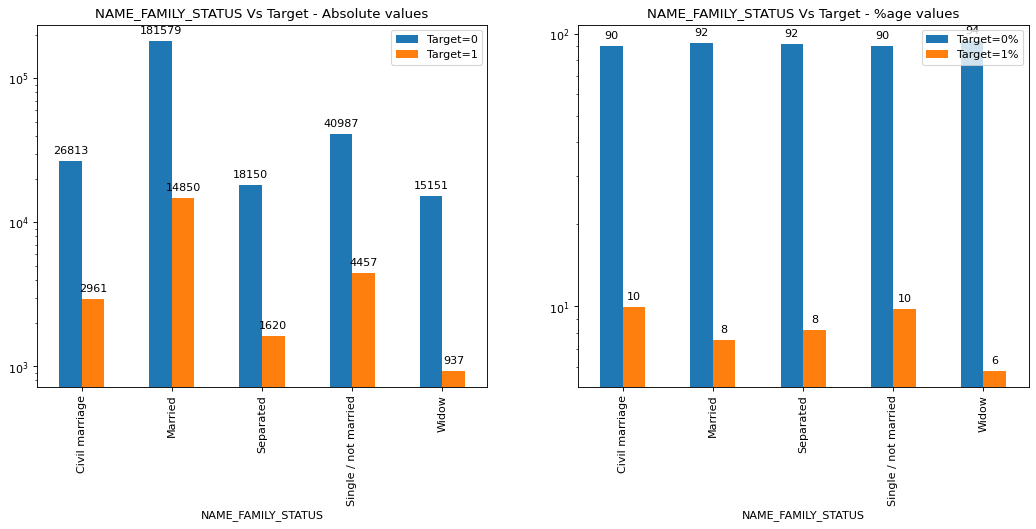

df_1: 24825, df_0: 282680
                      Total  Target=1  Target=0  Target=1%  Target=0%
NAME_HOUSING_TYPE                                                    
Co-op apartment        1122        89      1033       7.93      92.07
House / apartment    272864     21272    251592       7.80      92.20
Municipal apartment   11181       955     10226       8.54      91.46
Office apartment       2617       172      2445       6.57      93.43
Rented apartment       4881       601      4280      12.31      87.69
With parents          14840      1736     13104      11.70      88.30


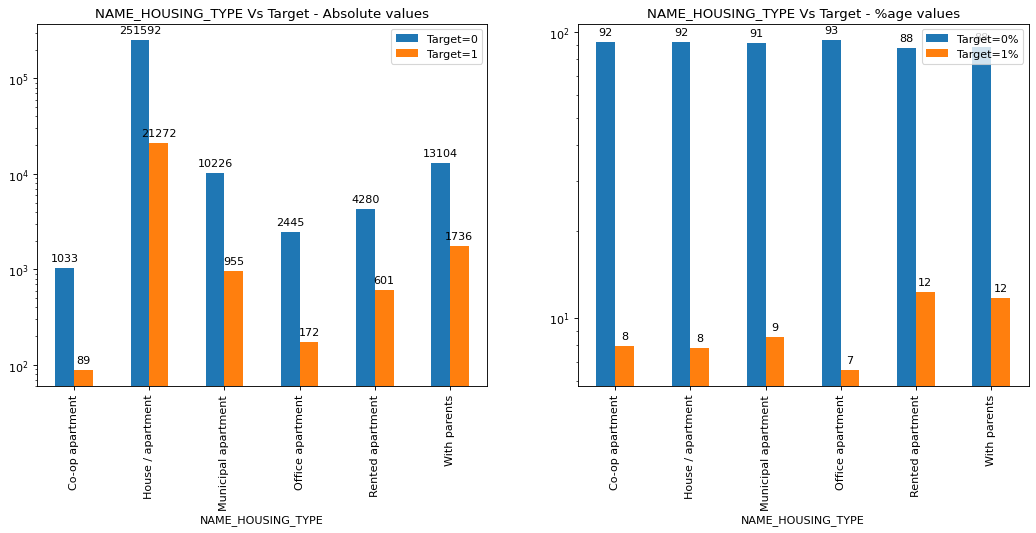

df_1: 24825, df_0: 282680
                              Total  Target=1  Target=0  Target=1%  Target=0%
REGION_RATING_CLIENT_W_CITY                                                  
1                             32197      1552     30645       4.82      95.18
2                            226979     17907    209072       7.89      92.11
3                             48329      5366     42963      11.10      88.90


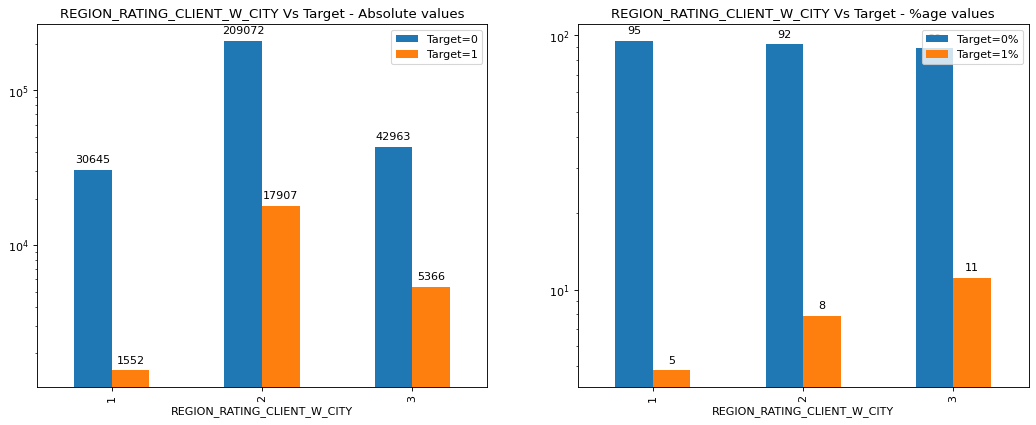

In [28]:
plotTargetWiseBarPlots(df_ca_demo_per, 'CODE_GENDER', 'Gender', labels=['Female', 'Male'])

for col in ['AGE', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_RATING_CLIENT_W_CITY']:
    plotTargetWiseBarPlots(df_ca_demo_per, col, col, figsize=(16, 6)) 

In [29]:
df_final = df_ca_demo_per.copy(deep=True)
print(df_final.shape, df_final.columns)

(307505, 11) Index(['CODE_GENDER', 'DAYS_BIRTH', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'REGION_RATING_CLIENT_W_CITY', 'SK_ID_CURR', 'TARGET', 'AGE'],
      dtype='object')


### Correlation

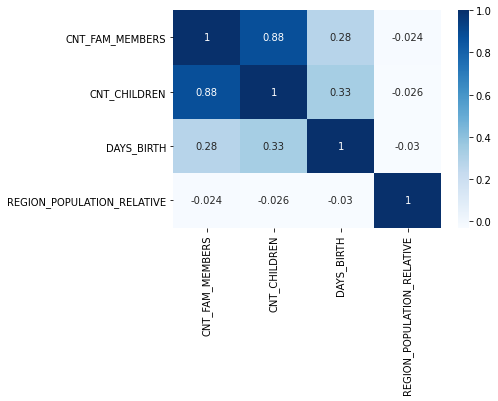

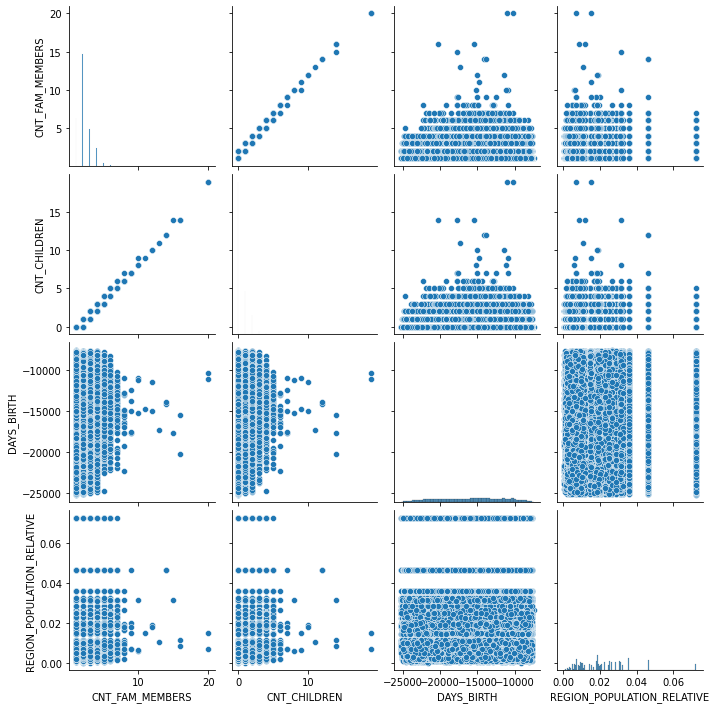

In [30]:
df_ = df_ca_demo_per[list(set(CA_DEMOGRAPHIC_PERSONAL_COLS)-set(['REGION_RATING_CLIENT']))]
sns.heatmap(df_.corr(), cmap="Blues", annot=True)
sns.pairplot(data=df_)

In [31]:
df_ca_demo_per.columns

Index(['CODE_GENDER', 'DAYS_BIRTH', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'REGION_RATING_CLIENT_W_CITY', 'SK_ID_CURR', 'TARGET', 'AGE'],
      dtype='object')

(307505, 11)
(24825, 11)


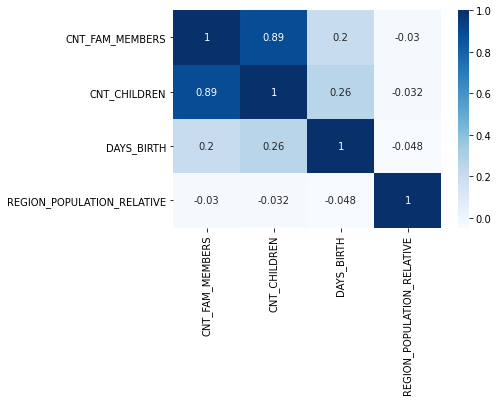

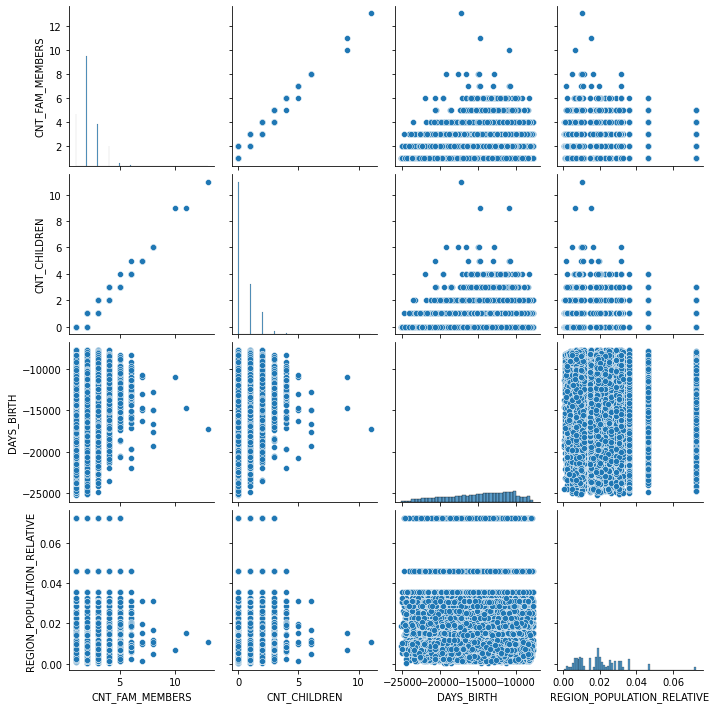

In [32]:
print(df_ca_demo_per.shape)

df_1 = df_ca_demo_per[df_ca_demo_per['TARGET']==1]; print(df_1.shape)
df_1 = df_1[list(set(CA_DEMOGRAPHIC_PERSONAL_COLS)-set(['REGION_RATING_CLIENT']))]
sns.heatmap(df_1.corr(), cmap="Blues", annot=True)
sns.pairplot(data=df_1)


(282680, 11)


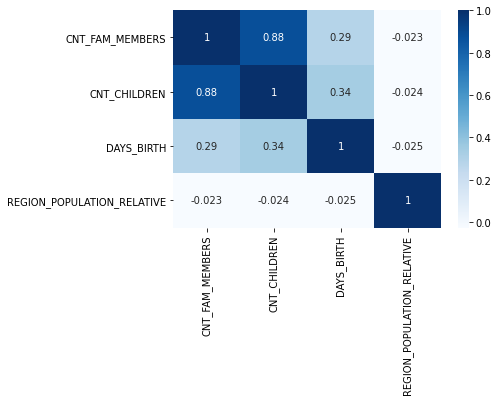

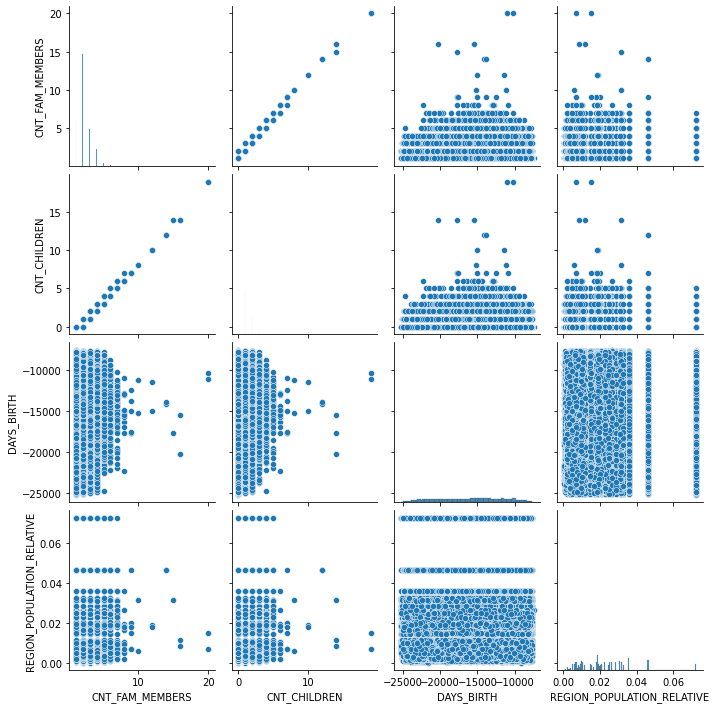

In [33]:
df_0 = df_ca_demo_per[df_ca_demo_per['TARGET']==0]; print(df_0.shape)
df_0 = df_0[list(set(CA_DEMOGRAPHIC_PERSONAL_COLS)-set(['REGION_RATING_CLIENT']))]
sns.heatmap(df_0.corr(), cmap="Blues", annot=True)
sns.pairplot(data=df_0)

- CNT_CHILDREN & CNT_FAM_MEMBERS have strong +ve correlation
- DAYS_BIRTH & CNT_CHILDREN have some correlation ??
- DAYS_BIRTH & CNT_FAM_MEMBERS have some correlation ??

No correlation:
- REGION_RATING_CLIENT & DAYS_BIRTH


### **OBSERVATIONS**
                            
| COLUMN(S) | Invalid values/Outliers? | Observation | Difficulties in paying | No difficulties in paying | 
|---|---|---|---|---|
| CODE_GENDER | None | More percentage of male clients have difficulties in paying | Male Clients | Female clients|
| DAYS_BIRTH --> AGE | None | Lesser age, more difficulty in paying | Younger Clients | Older clients|
| CNT_CHILDREN | > 2.5 till 19 | With increase in number of kids, the ability to pay decreases.| More children | Less children |
| CNT_FAM_MEMBERS | > 5 till 20 | With increase in number of family members, the ability to pay decreases | Larger family size | Smaller family size |
| NAME_FAMILY_STATUS | None | No clear observation | Civil Married <br> Single/Not Married | Widow |
| HOUSING_TYPE | None | Clients in Rented apartment or staying at parents house have difficulties in paying off |  | |
| REGION_POPULATION_RELATIVE | One value is highly populated | |  |  |
| REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY | None | Higher the region, the clients find it more difficult to pay. Clients from regions 3 have difficulty in paying off | Higher Region category | Lower Region category |

Majority of the clients are in
- HOUSING_TYPE- House/Apartment
- NAME_FAMILY_STATUS - Married
- CNT_FAM_MEMBERS = 2
- CNT_CHILDREN = 0
- Age: 30-40
- Female 
- REGION_RATING_CLIENT = 2

## 2. ANALYSIS: **Demographic - Professional**
Applicant's professional information

### Inspect

In [34]:
df_ca_demo_pro = getCategoryDf(df_ca, CA_DEMOGRAPHIC_PROFESSIONAL_COLS)
getGeneralInfo(df_ca_demo_pro)

Shape: (307511, 5)

Columns: ['NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'ORGANIZATION_TYPE', 'SK_ID_CURR', 'TARGET']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   NAME_EDUCATION_TYPE  307511 non-null  object
 1   NAME_INCOME_TYPE     307511 non-null  object
 2   ORGANIZATION_TYPE    307511 non-null  object
 3   SK_ID_CURR           307511 non-null  int64 
 4   TARGET               307511 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.7+ MB
None

Numerical values - describe:
             ORGANIZATION_TYPE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE
count                   307511           307511                         307511
unique                      58                8                              5
top     Business Entity Type 3          Working  Secondary / secondary special
freq               

### Handle Missing & Invalid values
| COLUMN(S) | Data type | Missing & Invalid value Strategy | 
|---|---|---|
| NAME_EDUCATION_TYPE | Categorical Ordered | _No missing/invalid values_ | 
| NAME_INCOME_TYPE | Categorical Unordered | _No missing/invalid values_ |  
| ORGANIZATION_TYPE | Categorical Unordered| _No missing/invalid values_ | 

### Analysis

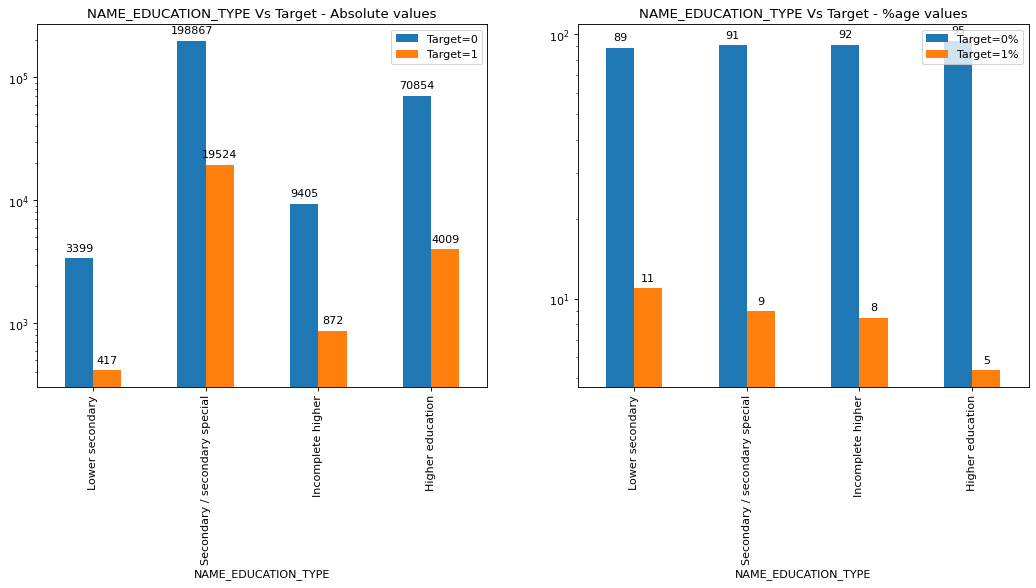

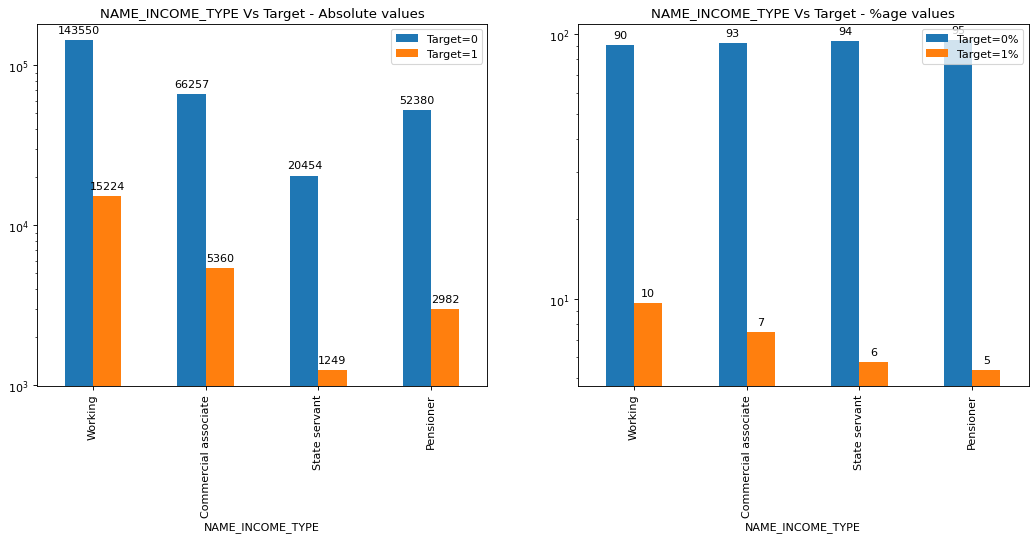

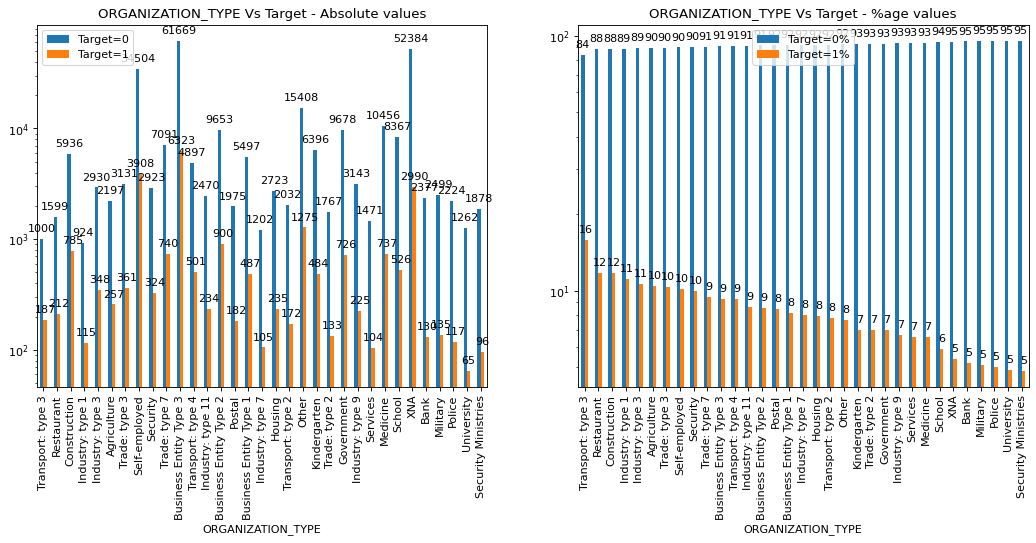

In [35]:
for col in CA_DEMOGRAPHIC_PROFESSIONAL_COLS:
    df_ = groupPerTargetLimited(df_ca_demo_pro, col)
    compareLimited(df_ca_demo_pro,col, col,figsize=(16, 6))

### Correlation
All are categroical variables. So there is no correlation required.

### **OBSERVATIONS**
| COLUMN(S) | Outliers? | Observation | Difficulties in paying | No difficulties in paying | 
|---|---|---|---|---|
| NAME_EDUCATION_TYPE | None | With increase in education, the ability to pay increases. | Clients with lesser education | Clients with higher education |
| NAME_INCOME_TYPE | None | None | Working | Pensioner, State Servant |
| ORGANIZATION_TYPE | None | None | Transport Type 3 | Bank |

## 3. ANALYSIS: **Character**
We will analyse the Character aspect of the applicant in the following sub categories
- 3.1 Applicant's credit history - a borrower's reputation or track record for repaying debts. How many previous applications were rejected?
- 3.2 Calls to Credit Bureau
- 3.3 Defaulters in social circle

### 3.1 Credit history
previous_application.csv has data about the previous applications (if any) of a particular applicant. Merge this data with the (current) application data using the SK_ID_CURR. The target dataset should have 
SK_ID_CURR, Total number of Previous Applications, How many rejected?, How many Accepted?

#### Read previous applicaiton data and inspect the data

In [36]:
df_pa_orig = pd.read_csv("data/previous_application.csv")
getGeneralInfo(df_pa_orig)

Shape: (1048575, 37)

Columns: ['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  

#### Handle missing data
- Drop columns that have > 50% missing data
- Drop columns that are not relevant

In [37]:
# Drop columns that have > 50% missing data
dropColumns(df_pa_orig, "*_DOWN_PAYMENT", ['AMT_DOWN_PAYMENT', 'RATE_DOWN_PAYMENT'])
dropColumns(df_pa_orig, "RATE_INTEREST_*", ['RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED'] )
dropColumns(df_pa_orig, "NAME_TYPE_SUITE", 'NAME_TYPE_SUITE')
dropColumns(df_pa_orig, "NAME_CASH_LOAN_PURPOSE", 'NAME_CASH_LOAN_PURPOSE')
dropColumns(df_pa_orig, "NAME_PRODUCT_TYPE", 'NAME_PRODUCT_TYPE')
dropColumns(df_pa_orig, "NAME_SELLER_INDUSTRY", 'NAME_SELLER_INDUSTRY')
dropColumns(df_pa_orig, "NAME_GOODS_CATEGORY", 'NAME_GOODS_CATEGORY')
dropColumns(df_pa_orig, "CODE_REJECT_REASON", 'CODE_REJECT_REASON')

# Drop columns that are not clear/relevant
dropColumns(df_pa_orig, "DAYS_*", ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION'])
dropColumns(df_pa_orig, "NFLAG_INSURED_ON_APPROVAL", 'NFLAG_INSURED_ON_APPROVAL')

Drop *_DOWN_PAYMENT 2 columns: Shape - before (1048575, 37) Shape - after (1048575, 35)
Drop RATE_INTEREST_* 2 columns: Shape - before (1048575, 35) Shape - after (1048575, 33)
Drop NAME_TYPE_SUITE 15 columns: Shape - before (1048575, 33) Shape - after (1048575, 32)
Drop NAME_CASH_LOAN_PURPOSE 22 columns: Shape - before (1048575, 32) Shape - after (1048575, 31)
Drop NAME_PRODUCT_TYPE 17 columns: Shape - before (1048575, 31) Shape - after (1048575, 30)
Drop NAME_SELLER_INDUSTRY 20 columns: Shape - before (1048575, 30) Shape - after (1048575, 29)
Drop NAME_GOODS_CATEGORY 19 columns: Shape - before (1048575, 29) Shape - after (1048575, 28)
Drop CODE_REJECT_REASON 18 columns: Shape - before (1048575, 28) Shape - after (1048575, 27)
Drop DAYS_* 5 columns: Shape - before (1048575, 27) Shape - after (1048575, 22)
Drop NFLAG_INSURED_ON_APPROVAL 25 columns: Shape - before (1048575, 22) Shape - after (1048575, 21)


In [38]:
listColumsWithMissingData(df_pa_orig);print()
listColumsWithInvalidData(df_pa_orig)

Columns with missing data: 4 19.05%
AMT_ANNUITY                      233009 22.22%
AMT_GOODS_PRICE                  240965 22.98%
CNT_PAYMENT                      233006 22.22%
PRODUCT_COMBINATION                 224 0.02%

Columns with invalid data:5
NAME_CONTRACT_TYPE: 224 0.02%
NAME_PAYMENT_TYPE: 392061 37.39%
NAME_CLIENT_TYPE: 1217 0.12%
NAME_PORTFOLIO: 233006 22.22%
NAME_YIELD_GROUP: 323941 30.89%



In [39]:
df_pa = df_pa_orig.copy(deep=True)

#### Merge the data
1. Create 2 pivot table - SK_ID_CURR & status of the application, SK_ID_CURR & number of applications
2. Merge them to create a single pa summary dataframe with SK_ID_CURR, number of applications, status of the application
3. Merge the previous application (pa) summary dataframe with the current application (ca) dataframe.
4. Create a PA_STATUS column to store the application status and a PrevApps column to store if there were Previous applications or not

In [40]:
df_pa.groupby(by='SK_ID_CURR').agg({'SK_ID_PREV':'count'})

SK_ID_PREV
SK_ID_CURR            
100001               1
100002               1
100003               2
100004               1
100006               4
...                ...
456251               1
456252               1
456253               1
456254               2
456255               6

[305828 rows x 1 columns]

In [41]:
# Create a pivot table - SK_ID_CURR & status of the application
df_pa_status = df_pa.pivot_table(index='SK_ID_CURR', values=['SK_ID_PREV'],columns=['NAME_CONTRACT_STATUS'], aggfunc=['count'],fill_value=0) 
df_pa_status.columns = df_pa_status.columns.droplevel()
df_pa_status.columns = df_pa_status.columns.droplevel()
print("df_pa_status");print(df_pa_status)

# Create another pivot table - SK_ID_CURR & number of applications
df_pa_counts = df_pa.pivot_table(index='SK_ID_CURR', values=['SK_ID_PREV'], aggfunc=['count'],fill_value=0) 
df_pa_counts.columns = df_pa_counts.columns.droplevel()
df_pa_counts.rename(columns={'SK_ID_PREV':'Total Prev Apps'}, inplace=True)
print("df_pa_counts"); print(df_pa_counts)

# Merge the pivot tables
#  to create a single pa summary dataframe with SK_ID_CURR, number of applications, status of the application
df_pa_summary = df_pa_counts.merge(df_pa_status, how='inner', on='SK_ID_CURR')
df_pa_summary.reset_index(inplace=True)
print("df_pa_summary"); print(df_pa_summary)

df_pa_status
NAME_CONTRACT_STATUS  Approved  Canceled  Refused  Unused offer
SK_ID_CURR                                                     
100001                       1         0        0             0
100002                       1         0        0             0
100003                       2         0        0             0
100004                       1         0        0             0
100006                       3         1        0             0
...                        ...       ...      ...           ...
456251                       1         0        0             0
456252                       1         0        0             0
456253                       1         0        0             0
456254                       2         0        0             0
456255                       4         0        2             0

[305828 rows x 4 columns]
df_pa_counts
            Total Prev Apps
SK_ID_CURR                 
100001                    1
100002                    1
100

In [42]:
# Get list of clients who do not have previous applications
pa_ids = df_pa_summary['SK_ID_CURR'].tolist(); print("Total previous applications: ", len(pa_ids))
print("Current Applications: ", df_ca.shape[0])
ca_ids_w_pa_ids = df_ca[df_ca['SK_ID_CURR'].isin(pa_ids)]['SK_ID_CURR'].shape[0]
ca_ids_wo_pa_ids = df_ca[~df_ca['SK_ID_CURR'].isin(pa_ids)]['SK_ID_CURR']
print("Number of clients with previous applications:", ca_ids_w_pa_ids)
print("Number of clients with no previous applications:", len(ca_ids_wo_pa_ids))

Total previous applications:  305828
Current Applications:  307511
Number of clients with previous applications: 262331
Number of clients with no previous applications: 45180


In [43]:
# Merge the previous application (pa) summary dataframe with the current application (ca) dataframe.
df_pa_ca = df_ca.merge(df_pa_summary, how='left', on='SK_ID_CURR')
print("Before\n", df_pa_ca.isna().sum())
df_pa_ca[['Total Prev Apps','Approved', 'Canceled',	'Refused','Unused offer']] = df_pa_ca[['Total Prev Apps','Approved','Canceled',	'Refused','Unused offer']].fillna(0)
print("After\n", df_pa_ca.isna().sum())
df_pa_ca[['SK_ID_CURR','TARGET','Total Prev Apps','Approved', 'Canceled',	'Refused',	'Unused offer']]

Before
 SK_ID_CURR                0
TARGET                    0
NAME_CONTRACT_TYPE        0
CODE_GENDER               0
FLAG_OWN_CAR              0
                      ...  
Total Prev Apps       45180
Approved              45180
Canceled              45180
Refused               45180
Unused offer          45180
Length: 74, dtype: int64
After
 SK_ID_CURR            0
TARGET                0
NAME_CONTRACT_TYPE    0
CODE_GENDER           0
FLAG_OWN_CAR          0
                     ..
Total Prev Apps       0
Approved              0
Canceled              0
Refused               0
Unused offer          0
Length: 74, dtype: int64


SK_ID_CURR  TARGET  Total Prev Apps  Approved  Canceled  Refused  \
0           100002       1              1.0       1.0       0.0      0.0   
1           100003       0              2.0       2.0       0.0      0.0   
2           100004       0              1.0       1.0       0.0      0.0   
3           100006       0              4.0       3.0       1.0      0.0   
4           100007       0              3.0       3.0       0.0      0.0   
...            ...     ...              ...       ...       ...      ...   
307506      456251       0              1.0       1.0       0.0      0.0   
307507      456252       0              1.0       1.0       0.0      0.0   
307508      456253       0              1.0       1.0       0.0      0.0   
307509      456254       1              2.0       2.0       0.0      0.0   
307510      456255       0              6.0       4.0       0.0      2.0   

        Unused offer  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  
...              ...  
307506           0.0  
307507           0.0  
307508           0.0  
307509           0.0  
307510           0.0  

[307511 rows x 7 columns]

In [44]:
def getPAStatus(x):
    if  x['Total Prev Apps'] == 0: return "NO_PREV_APPS"
    elif x['Refused'] > 0: return 'REFUSED'
    elif x['Approved'] > 0: return 'APPROVED'
    else: return 'OTHERS'

# Create a PA_STATUS column to store the application status
df_pa_ca['PA_STATUS'] = df_pa_ca.apply(getPAStatus, axis=1)

# Create a PrevApps column to store if there were Previous applications or not
df_pa_ca['PrevApps'] = df_pa_ca['Total Prev Apps'] > 0 

In [45]:
df_pa_ca[['SK_ID_CURR', 'PA_STATUS', 'PrevApps', 'Total Prev Apps','Approved',	'Canceled',	'Refused', 'Unused offer']]

SK_ID_CURR PA_STATUS  PrevApps  Total Prev Apps  Approved  Canceled  \
0           100002  APPROVED      True              1.0       1.0       0.0   
1           100003  APPROVED      True              2.0       2.0       0.0   
2           100004  APPROVED      True              1.0       1.0       0.0   
3           100006  APPROVED      True              4.0       3.0       1.0   
4           100007  APPROVED      True              3.0       3.0       0.0   
...            ...       ...       ...              ...       ...       ...   
307506      456251  APPROVED      True              1.0       1.0       0.0   
307507      456252  APPROVED      True              1.0       1.0       0.0   
307508      456253  APPROVED      True              1.0       1.0       0.0   
307509      456254  APPROVED      True              2.0       2.0       0.0   
307510      456255   REFUSED      True              6.0       4.0       0.0   

        Refused  Unused offer  
0           0.0           0.0  
1           0.0           0.0  
2           0.0           0.0  
3           0.0           0.0  
4           0.0           0.0  
...         ...           ...  
307506      0.0           0.0  
307507      0.0           0.0  
307508      0.0           0.0  
307509      0.0           0.0  
307510      2.0           0.0  

[307511 rows x 8 columns]

#### Analyse

df_1: 24825, df_0: 282686
           Total  Target=1  Target=0  Target=1%  Target=0%
PrevApps                                                  
False      45180      3406     41774       7.54      92.46
True      262331     21419    240912       8.16      91.84


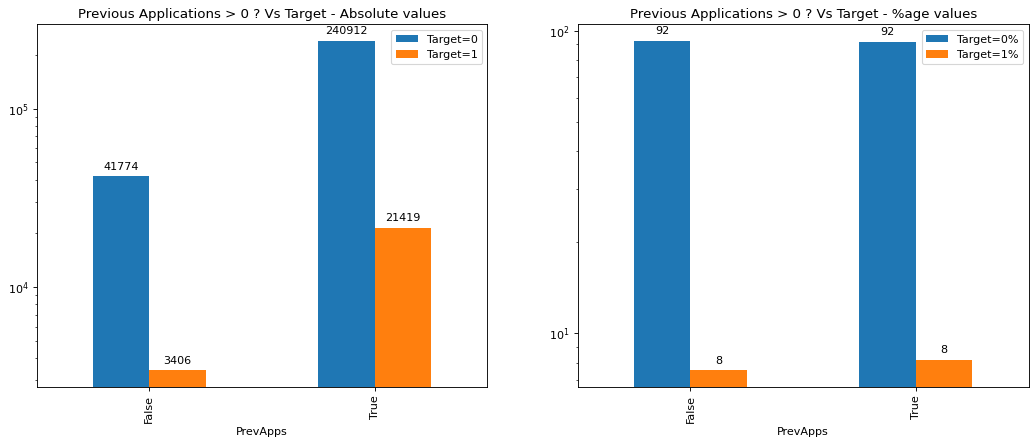

df_1: 24825, df_0: 282686
               Total  Target=1  Target=0  Target=1%  Target=0%
PA_STATUS                                                     
APPROVED      177282     12524    164758       7.06      92.94
NO_PREV_APPS   45180      3406     41774       7.54      92.46
OTHERS          6030       488      5542       8.09      91.91
REFUSED        79019      8407     70612      10.64      89.36


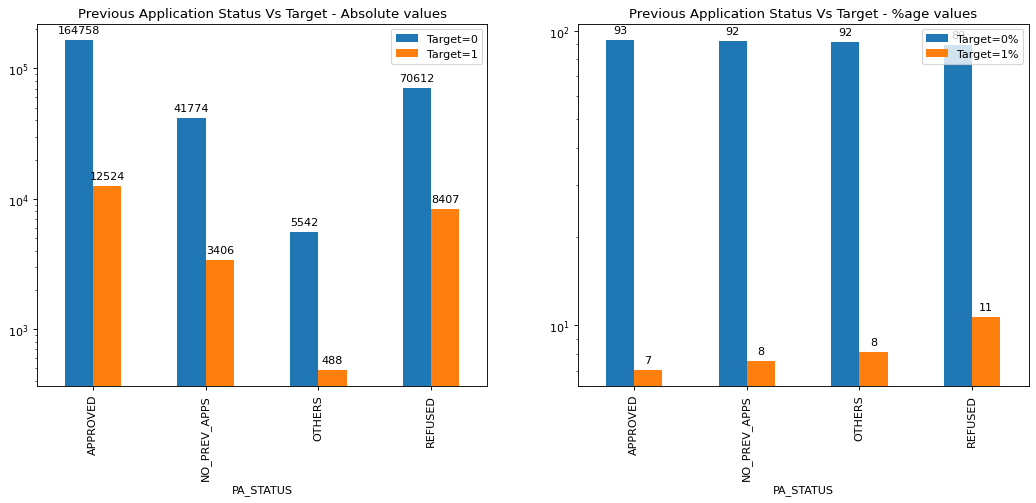

In [46]:
plotTargetWiseBarPlots(df_pa_ca, 'PrevApps', 'Previous Applications > 0 ?', figsize=(16, 6)) 
plotTargetWiseBarPlots(df_pa_ca, 'PA_STATUS', 'Previous Application Status', figsize=(16, 6)) 

- Having Prev Apps does not indicate any difficulty or otherwise 
- Clients with refused previous applications are likely to have diffiuclties in paying  


In [47]:
# Update df_final for corelation analysis
df_final = df_final.merge(df_pa_ca[['SK_ID_CURR', 'PA_STATUS', 'PrevApps', 'Total Prev Apps','Approved',	'Canceled',	'Refused',	'Unused offer']], how='inner', on='SK_ID_CURR')
print(df_final.shape, df_final.columns)

(307505, 18) Index(['CODE_GENDER', 'DAYS_BIRTH', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'REGION_RATING_CLIENT_W_CITY', 'SK_ID_CURR', 'TARGET', 'AGE',
       'PA_STATUS', 'PrevApps', 'Total Prev Apps', 'Approved', 'Canceled',
       'Refused', 'Unused offer'],
      dtype='object')


### 3.2 Calls to Credit Bureau
Check if the calls to credit bureau are an indicator of a clients capability to pay

#### Inspect

In [48]:
df_ca_character = getCategoryDf(df_ca, CA_CHARACTER_COLS)
getGeneralInfo(df_ca_character)

Shape: (307511, 8)

Columns: ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'SK_ID_CURR', 'TARGET']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AMT_REQ_CREDIT_BUREAU_HOUR  265992 non-null  float64
 1   AMT_REQ_CREDIT_BUREAU_DAY   265992 non-null  float64
 2   AMT_REQ_CREDIT_BUREAU_WEEK  265992 non-null  float64
 3   AMT_REQ_CREDIT_BUREAU_MON   265992 non-null  float64
 4   AMT_REQ_CREDIT_BUREAU_QRT   265992 non-null  float64
 5   AMT_REQ_CREDIT_BUREAU_YEAR  265992 non-null  float64
 6   SK_ID_CURR                  307511 non-null  int64  
 7   TARGET                      307511 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 18.8 MB
None

Numerical values - de

All AMT_REQ_CREDIT_BUREAU_* columns are missing 13.5% of values. Check if they are all missing the same Client's data.

In [49]:
df_ca_character_nans = df_ca_character[(df_ca_character['AMT_REQ_CREDIT_BUREAU_HOUR'].isna()) & (df_ca_character['AMT_REQ_CREDIT_BUREAU_DAY'].isna())
                        & (df_ca_character['AMT_REQ_CREDIT_BUREAU_WEEK'].isna()) & (df_ca_character['AMT_REQ_CREDIT_BUREAU_MON'].isna())
                        & (df_ca_character['AMT_REQ_CREDIT_BUREAU_QRT'].isna()) & (df_ca_character['AMT_REQ_CREDIT_BUREAU_YEAR'].isna())]
print(df_ca_character_nans.shape[0], df_ca_character.shape[0], percent(df_ca_character_nans.shape[0], df_ca_character.shape[0]))

41519 307511 13.5


This shows that either all the columns are filled or none of them are filled (NaN). So we can safely add the values of all the columns

#### Handle Missing & Invalid values
| COLUMN(S) | Data type | Missing & Invalid value Strategy | 
|---|---|---|
| AMT_REQ_CREDIT_BUREAU_* | Numerical discrete | 13.5% missing values <br> - Add values from all the columns into a single column "ENQUIRIES_CREDIT_BUREAU" which will give the total number of calls in one year before application. <br> - Either all the columns are filled or none of them are filled (NaN). So we can safelt add the values of all the columns <br> - Fill the na value with meadian | 

In [50]:
df_ca_character['ENQUIRIES_CREDIT_BUREAU'] = 0
for col in CA_CHARACTER_COLS:
    df_ca_character['ENQUIRIES_CREDIT_BUREAU'] += df_ca_character[col] 
listColumsWithMissingData(df_ca_character)

Columns with missing data: 7 77.78%
AMT_REQ_CREDIT_BUREAU_HOUR        41519 13.5%
AMT_REQ_CREDIT_BUREAU_DAY         41519 13.5%
AMT_REQ_CREDIT_BUREAU_WEEK        41519 13.5%
AMT_REQ_CREDIT_BUREAU_MON         41519 13.5%
AMT_REQ_CREDIT_BUREAU_QRT         41519 13.5%
AMT_REQ_CREDIT_BUREAU_YEAR        41519 13.5%
ENQUIRIES_CREDIT_BUREAU           41519 13.5%


In [51]:
 # Find the median value to fill the missing values
 ENQUIRIES_CREDIT_BUREAU_MEDIAN = df_ca_character['ENQUIRIES_CREDIT_BUREAU'].median()

Let's also add a ENQUIRIES_CREDIT_BUREAU_CAT column that indicate if there were calls, no calls or no information

In [52]:
def convertToCategory(x):
    if x == 0: return 'N'
    elif x > 0: return 'Y'
    else: return 'No Information'

df_ca_character['ENQUIRIES_CREDIT_BUREAU_CAT'] = df_ca_character['ENQUIRIES_CREDIT_BUREAU'].apply(convertToCategory)
print("Missing values:"); print(df_ca_character.isna().sum(), percent(df_ca_character.isna().sum(),df_ca_character.shape[0]))
df_ca_character.groupby(by='ENQUIRIES_CREDIT_BUREAU_CAT').agg({'ENQUIRIES_CREDIT_BUREAU_CAT':'count'})
df_ca_character

Missing values:
AMT_REQ_CREDIT_BUREAU_HOUR     41519
AMT_REQ_CREDIT_BUREAU_DAY      41519
AMT_REQ_CREDIT_BUREAU_WEEK     41519
AMT_REQ_CREDIT_BUREAU_MON      41519
AMT_REQ_CREDIT_BUREAU_QRT      41519
AMT_REQ_CREDIT_BUREAU_YEAR     41519
SK_ID_CURR                         0
TARGET                             0
ENQUIRIES_CREDIT_BUREAU        41519
ENQUIRIES_CREDIT_BUREAU_CAT        0
dtype: int64 AMT_REQ_CREDIT_BUREAU_HOUR     13.5
AMT_REQ_CREDIT_BUREAU_DAY      13.5
AMT_REQ_CREDIT_BUREAU_WEEK     13.5
AMT_REQ_CREDIT_BUREAU_MON      13.5
AMT_REQ_CREDIT_BUREAU_QRT      13.5
AMT_REQ_CREDIT_BUREAU_YEAR     13.5
SK_ID_CURR                      0.0
TARGET                          0.0
ENQUIRIES_CREDIT_BUREAU        13.5
ENQUIRIES_CREDIT_BUREAU_CAT     0.0
dtype: float64


AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                              0.0                        0.0   
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              NaN                        NaN   
4                              0.0                        0.0   
...                            ...                        ...   
307506                         NaN                        NaN   
307507                         NaN                        NaN   
307508                         1.0                        0.0   
307509                         0.0                        0.0   
307510                         0.0                        0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                              0.0                        0.0   
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              NaN                        NaN   
4                              0.0                        0.0   
...                            ...                        ...   
307506                         NaN                        NaN   
307507                         NaN                        NaN   
307508                         0.0                        1.0   
307509                         0.0                        0.0   
307510                         0.0                        2.0   

        AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  SK_ID_CURR  \
0                             0.0                         1.0      100002   
1                             0.0                         0.0      100003   
2                             0.0                         0.0      100004   
3                             NaN                         NaN      100006   
4                             0.0                         0.0      100007   
...                           ...                         ...         ...   
307506                        NaN                         NaN      456251   
307507                        NaN                         NaN      456252   
307508                        0.0                         1.0      456253   
307509                        0.0                         0.0      456254   
307510                        0.0                         1.0      456255   

        TARGET  ENQUIRIES_CREDIT_BUREAU ENQUIRIES_CREDIT_BUREAU_CAT  
0            1                      1.0                           Y  
1            0                      0.0                           N  
2            0                      0.0                           N  
3            0                      NaN              No Information  
4            0                      0.0                           N  
...        ...                      ...                         ...  
307506       0                      NaN              No Information  
307507       0                      NaN              No Information  
307508       0                      3.0                           Y  
307509       1                      0.0                           N  
307510       0                      3.0                           Y  

[307511 rows x 10 columns]

In [53]:
df_ca_character['ENQUIRIES_CREDIT_BUREAU'] = df_ca_character['ENQUIRIES_CREDIT_BUREAU'].fillna(ENQUIRIES_CREDIT_BUREAU_MEDIAN)

In [54]:
listColumsWithMissingData(df_ca_character)

Columns with missing data: 6 60.0%
AMT_REQ_CREDIT_BUREAU_HOUR        41519 13.5%
AMT_REQ_CREDIT_BUREAU_DAY         41519 13.5%
AMT_REQ_CREDIT_BUREAU_WEEK        41519 13.5%
AMT_REQ_CREDIT_BUREAU_MON         41519 13.5%
AMT_REQ_CREDIT_BUREAU_QRT         41519 13.5%
AMT_REQ_CREDIT_BUREAU_YEAR        41519 13.5%


#### Analyse

<AxesSubplot:title={'center':'ENQUIRIES_CREDIT_BUREAU'}, xlabel='TARGET'>

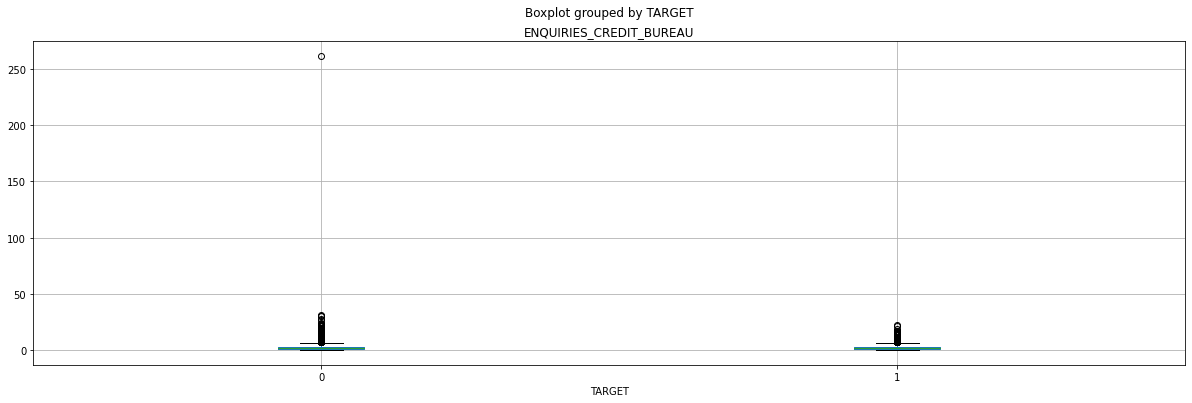

In [55]:
df_ca_character.boxplot(column='ENQUIRIES_CREDIT_BUREAU', by='TARGET', figsize = (20, 6))

<AxesSubplot:title={'center':'ENQUIRIES_CREDIT_BUREAU'}, xlabel='TARGET'>

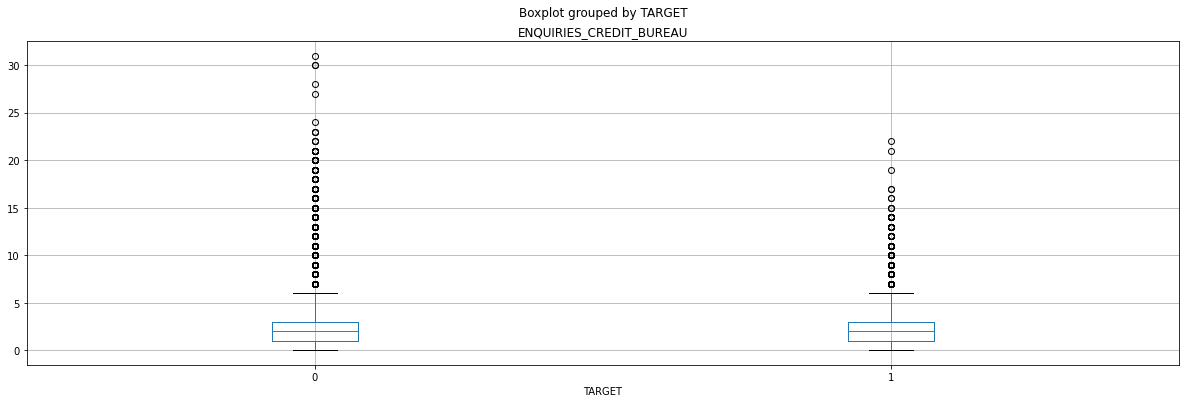

In [56]:
# There is an outlier 262. Let's remove it to understand the typical data spread
df_ca_character = df_ca_character[df_ca_character['ENQUIRIES_CREDIT_BUREAU']!=262]
df_ca_character.boxplot(column='ENQUIRIES_CREDIT_BUREAU', by='TARGET', figsize = (20, 6))

The calls to the credit bureau (for both Target=0 and Target=1) seem to be following a similar pattern

In [57]:
# Update df_final for corelation analysis
df_final = df_final.merge(df_ca_character[['SK_ID_CURR', 'ENQUIRIES_CREDIT_BUREAU']], how='inner', on='SK_ID_CURR')
print(df_final.shape, df_final.columns)

(307504, 19) Index(['CODE_GENDER', 'DAYS_BIRTH', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'REGION_RATING_CLIENT_W_CITY', 'SK_ID_CURR', 'TARGET', 'AGE',
       'PA_STATUS', 'PrevApps', 'Total Prev Apps', 'Approved', 'Canceled',
       'Refused', 'Unused offer', 'ENQUIRIES_CREDIT_BUREAU'],
      dtype='object')


Plot a bar graph comparing the values for Target=1 & Target=0

df_1: 24825, df_0: 282685
                           Total  Target=1  Target=0  Target=1%  Target=0%
ENQUIRIES_CREDIT_BUREAU                                                   
0.0                      50911.0    3755.0     47156       7.38      92.62
1.0                      53914.0    3997.0     49917       7.41      92.59
2.0                      93078.0    8265.0     84813       8.88      91.12
3.0                      39380.0    3036.0     36344       7.71      92.29
4.0                      27241.0    2160.0     25081       7.93      92.07
5.0                      17248.0    1445.0     15803       8.38      91.62
6.0                      10775.0     883.0      9892       8.19      91.81
7.0                       6428.0     578.0      5850       8.99      91.01
8.0                       3834.0     318.0      3516       8.29      91.71
9.0                       2273.0     217.0      2056       9.55      90.45
10.0                      1055.0      80.0       975       7.58      92.42

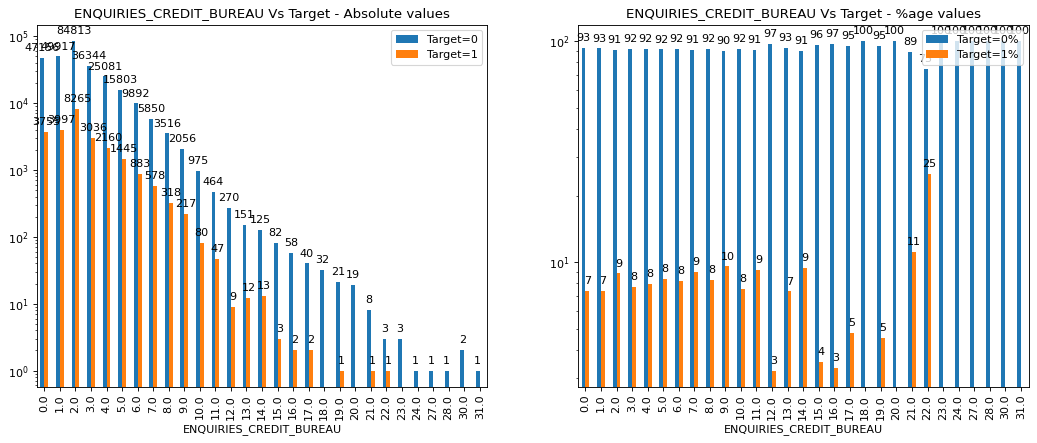

df_1: 24825, df_0: 282685
                              Total  Target=1  Target=0  Target=1%  Target=0%
ENQUIRIES_CREDIT_BUREAU_CAT                                                  
N                             50911      3755     47156       7.38      92.62
No Information                41519      4292     37227      10.34      89.66
Y                            215080     16778    198302       7.80      92.20


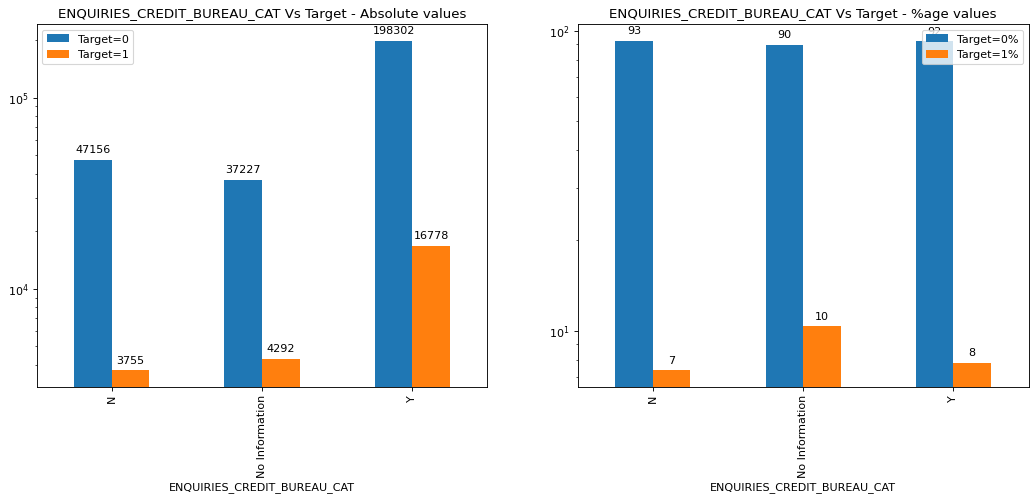

In [58]:
plotTargetWiseBarPlots(df_ca_character,'ENQUIRIES_CREDIT_BUREAU', 'ENQUIRIES_CREDIT_BUREAU',figsize=(16, 6))
plotTargetWiseBarPlots(df_ca_character,'ENQUIRIES_CREDIT_BUREAU_CAT', 'ENQUIRIES_CREDIT_BUREAU_CAT',figsize=(16, 6))

Whether there were calls to Credit Bureau or not does not seem to indicate clients capability to pay loans

### 3.3 Defaulters in Social circle

#### Inspect dataset

In [59]:
df_ca_social = getCategoryDf(df_ca, CA_SOCIAL_CIRCLE_COLS)
getGeneralInfo(df_ca_social)

Shape: (307511, 6)

Columns: ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'SK_ID_CURR', 'TARGET']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 6 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   OBS_30_CNT_SOCIAL_CIRCLE  306490 non-null  float64
 1   DEF_30_CNT_SOCIAL_CIRCLE  306490 non-null  float64
 2   OBS_60_CNT_SOCIAL_CIRCLE  306490 non-null  float64
 3   DEF_60_CNT_SOCIAL_CIRCLE  306490 non-null  float64
 4   SK_ID_CURR                307511 non-null  int64  
 5   TARGET                    307511 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 14.1 MB
None

Numerical values - describe:
       OBS_30_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
count             306490.000000             306490.000000   
mean                   1.422245                  0.100049   
std   

In [60]:
# Add all the OBServations and DEFault values and calculate the PERCENT of defaulters in the client's social circle
df_ca_social['OBS_CNT_SOCIAL_CIRCLE'] = df_ca_social['OBS_30_CNT_SOCIAL_CIRCLE'] + df_ca_social['OBS_60_CNT_SOCIAL_CIRCLE']
df_ca_social['DEF_CNT_SOCIAL_CIRCLE'] = df_ca_social['DEF_30_CNT_SOCIAL_CIRCLE'] + df_ca_social['DEF_60_CNT_SOCIAL_CIRCLE']
df_ca_social[['OBS_CNT_SOCIAL_CIRCLE','DEF_CNT_SOCIAL_CIRCLE']]

OBS_CNT_SOCIAL_CIRCLE  DEF_CNT_SOCIAL_CIRCLE
0                         4.0                    4.0
1                         2.0                    0.0
2                         0.0                    0.0
3                         4.0                    0.0
4                         0.0                    0.0
...                       ...                    ...
307506                    0.0                    0.0
307507                    0.0                    0.0
307508                   12.0                    0.0
307509                    0.0                    0.0
307510                    0.0                    0.0

[307511 rows x 2 columns]

In [61]:
listColumsWithMissingData(df_ca_social)

Columns with missing data: 6 75.0%
OBS_30_CNT_SOCIAL_CIRCLE           1021 0.33%
DEF_30_CNT_SOCIAL_CIRCLE           1021 0.33%
OBS_60_CNT_SOCIAL_CIRCLE           1021 0.33%
DEF_60_CNT_SOCIAL_CIRCLE           1021 0.33%
OBS_CNT_SOCIAL_CIRCLE              1021 0.33%
DEF_CNT_SOCIAL_CIRCLE              1021 0.33%


#### Handle missing values

In [62]:
df_ca_social['OBS_CNT_SOCIAL_CIRCLE'] = df_ca_social['OBS_CNT_SOCIAL_CIRCLE'].fillna(df_ca_social['OBS_CNT_SOCIAL_CIRCLE'].median())
df_ca_social['DEF_CNT_SOCIAL_CIRCLE'] = df_ca_social['DEF_CNT_SOCIAL_CIRCLE'].fillna(df_ca_social['DEF_CNT_SOCIAL_CIRCLE'].median())

In [63]:
listColumsWithMissingData(df_ca_social)

Columns with missing data: 4 50.0%
OBS_30_CNT_SOCIAL_CIRCLE           1021 0.33%
DEF_30_CNT_SOCIAL_CIRCLE           1021 0.33%
OBS_60_CNT_SOCIAL_CIRCLE           1021 0.33%
DEF_60_CNT_SOCIAL_CIRCLE           1021 0.33%


In [64]:
df_ca_social

OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
0                            2.0                       2.0   
1                            1.0                       0.0   
2                            0.0                       0.0   
3                            2.0                       0.0   
4                            0.0                       0.0   
...                          ...                       ...   
307506                       0.0                       0.0   
307507                       0.0                       0.0   
307508                       6.0                       0.0   
307509                       0.0                       0.0   
307510                       0.0                       0.0   

        OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  SK_ID_CURR  \
0                            2.0                       2.0      100002   
1                            1.0                       0.0      100003   
2                            0.0                       0.0      100004   
3                            2.0                       0.0      100006   
4                            0.0                       0.0      100007   
...                          ...                       ...         ...   
307506                       0.0                       0.0      456251   
307507                       0.0                       0.0      456252   
307508                       6.0                       0.0      456253   
307509                       0.0                       0.0      456254   
307510                       0.0                       0.0      456255   

        TARGET  OBS_CNT_SOCIAL_CIRCLE  DEF_CNT_SOCIAL_CIRCLE  
0            1                    4.0                    4.0  
1            0                    2.0                    0.0  
2            0                    0.0                    0.0  
3            0                    4.0                    0.0  
4            0                    0.0                    0.0  
...        ...                    ...                    ...  
307506       0                    0.0                    0.0  
307507       0                    0.0                    0.0  
307508       0                   12.0                    0.0  
307509       1                    0.0                    0.0  
307510       0                    0.0                    0.0  

[307511 rows x 8 columns]

In [65]:
# REduce the number of columns. Calculate total percent of defaulters
df_ca_social['DEF_PC_SOCIAL_CIRCLE'] = percent( df_ca_social['DEF_CNT_SOCIAL_CIRCLE'], df_ca_social['OBS_CNT_SOCIAL_CIRCLE'])
df_ca_social['DEF_PC_SOCIAL_CIRCLE'] = df_ca_social['DEF_PC_SOCIAL_CIRCLE'].fillna(0)
df_ca_social[['SK_ID_CURR','OBS_CNT_SOCIAL_CIRCLE','DEF_CNT_SOCIAL_CIRCLE', 'DEF_PC_SOCIAL_CIRCLE']]

SK_ID_CURR  OBS_CNT_SOCIAL_CIRCLE  DEF_CNT_SOCIAL_CIRCLE  \
0           100002                    4.0                    4.0   
1           100003                    2.0                    0.0   
2           100004                    0.0                    0.0   
3           100006                    4.0                    0.0   
4           100007                    0.0                    0.0   
...            ...                    ...                    ...   
307506      456251                    0.0                    0.0   
307507      456252                    0.0                    0.0   
307508      456253                   12.0                    0.0   
307509      456254                    0.0                    0.0   
307510      456255                    0.0                    0.0   

        DEF_PC_SOCIAL_CIRCLE  
0                      100.0  
1                        0.0  
2                        0.0  
3                        0.0  
4                        0.0  
...                      ...  
307506                   0.0  
307507                   0.0  
307508                   0.0  
307509                   0.0  
307510                   0.0  

[307511 rows x 4 columns]

In [66]:
listColumsWithMissingData(df_ca_social)

Columns with missing data: 4 44.44%
OBS_30_CNT_SOCIAL_CIRCLE           1021 0.33%
DEF_30_CNT_SOCIAL_CIRCLE           1021 0.33%
OBS_60_CNT_SOCIAL_CIRCLE           1021 0.33%
DEF_60_CNT_SOCIAL_CIRCLE           1021 0.33%


In [67]:
df_ca_social['DEF_PC_SOCIAL_CIRCLE'].describe()

count    307511.000000
mean          5.852451
std          19.789767
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         100.000000
Name: DEF_PC_SOCIAL_CIRCLE, dtype: float64

In [68]:
# Update df_final for corelation analysis
df_final = df_final.merge(df_ca_social[['SK_ID_CURR', 'DEF_PC_SOCIAL_CIRCLE']], how='inner', on='SK_ID_CURR')
print(df_final.shape, df_final.columns)

(307504, 20) Index(['CODE_GENDER', 'DAYS_BIRTH', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'REGION_RATING_CLIENT_W_CITY', 'SK_ID_CURR', 'TARGET', 'AGE',
       'PA_STATUS', 'PrevApps', 'Total Prev Apps', 'Approved', 'Canceled',
       'Refused', 'Unused offer', 'ENQUIRIES_CREDIT_BUREAU',
       'DEF_PC_SOCIAL_CIRCLE'],
      dtype='object')


Bin the social defaulters to 0 or more than 0

In [69]:
df_ca_social_def = df_ca_social[['DEF_PC_SOCIAL_CIRCLE', 'TARGET']]
df_ca_social_def['DEF_PC_SOCIAL_CIRCLE'] = pd.cut(df_ca_social_def['DEF_PC_SOCIAL_CIRCLE'], [-10, 0, 100], labels=['0', '>0'])
df_ca_social_def

DEF_PC_SOCIAL_CIRCLE  TARGET
0                        >0       1
1                         0       0
2                         0       0
3                         0       0
4                         0       0
...                     ...     ...
307506                    0       0
307507                    0       0
307508                    0       0
307509                    0       1
307510                    0       0

[307511 rows x 2 columns]

#### Aanlyse

df_1: 24825, df_0: 282686
                          Total  Target=1  Target=0  Target=1%  Target=0%
DEF_CNT_SOCIAL_CIRCLE                                                    
0.0                    272345.0   21134.0    251211       7.76      92.24
1.0                      8466.0     803.0      7663       9.48      90.52
2.0                     20656.0    2151.0     18505      10.41      89.59
3.0                      1890.0     204.0      1686      10.79      89.21
4.0                      2952.0     374.0      2578      12.67      87.33
5.0                       401.0      38.0       363       9.48      90.52
6.0                       565.0      95.0       470      16.81      83.19
7.0                        64.0       5.0        59       7.81      92.19
8.0                       118.0      15.0       103      12.71      87.29
9.0                        25.0       3.0        22      12.00      88.00
10.0                       21.0       2.0        19       9.52      90.48
11.0        

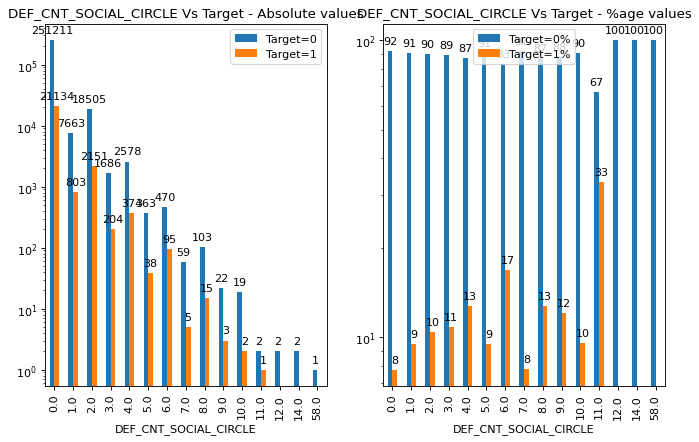

In [70]:
plotTargetWiseBarPlots(df_ca_social, 'DEF_CNT_SOCIAL_CIRCLE', 'DEF_CNT_SOCIAL_CIRCLE')

df_1: 24825, df_0: 282686
                       Total  Target=1  Target=0  Target=1%  Target=0%
DEF_PC_SOCIAL_CIRCLE                                                  
0                     272345     21134    251211       7.76      92.24
>0                     35166      3691     31475      10.50      89.50


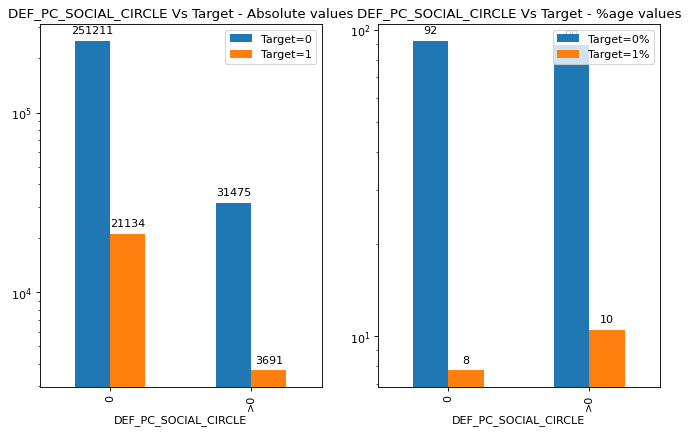

In [71]:
plotTargetWiseBarPlots(df_ca_social_def, 'DEF_PC_SOCIAL_CIRCLE', 'DEF_PC_SOCIAL_CIRCLE')

### **OBSERVATIONS**
| COLUMN(S) | Outliers? | Observation | Difficulties in paying | No difficulties in paying | 
|---|---|---|---|---|
| PREV_APPS | None | Having Prev Apps does not indicate any difficulty or otherwise  | With PrevApps refused |  |
| ENQUIRIES_CREDIT_BUREAU | Whether there were calls to Credit Bureau or not does not seem to indicate clients capability to pay loans  |  NA | NA |
| SOCIAL_CIRCLE_DEFAULT_% | None | Clients with defaulters in social circle | Clients with higher percentage of defaulters in social circle  |  Clients with lesser %age of defaulters in social circle |

## 4. ANALYSIS: **Capacity**
- Applicant's debt-to-income ratio measures the borrower's ability to repay a loan by comparing income against recurring debts.Borrower's total monthly debt payments and dividing that by the borrower's gross monthly income.an applicant's DTI to be around 35% or less.
- Income, Credit, Goods 

### Inspect

In [72]:
df_ca_capacity = df_ca[CA_AMOUNT_COLS + ['SK_ID_CURR', 'TARGET', 'DAYS_EMPLOYED']]
getGeneralInfo(df_ca_capacity)

Shape: (307511, 7)

Columns: ['AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 'AMT_ANNUITY', 'SK_ID_CURR', 'TARGET', 'DAYS_EMPLOYED']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   AMT_INCOME_TOTAL  307511 non-null  float64
 1   AMT_GOODS_PRICE   307233 non-null  float64
 2   AMT_CREDIT        307511 non-null  float64
 3   AMT_ANNUITY       307499 non-null  float64
 4   SK_ID_CURR        307511 non-null  int64  
 5   TARGET            307511 non-null  int64  
 6   DAYS_EMPLOYED     307511 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 16.4 MB
None

Numerical values - describe:
         AMT_ANNUITY    AMT_CREDIT  AMT_GOODS_PRICE  DAYS_EMPLOYED  \
count  307499.000000  3.075110e+05     3.072330e+05  307511.000000   
mean    27108.573909  5.990260e+05     5.383962e+05   63815.045904   
std     14493.737315  

AMT_GOODS_PRICE, AMT_ANNUITY have missing data. Let's check the median values

- How much is the annuity (wrt to the loan amount)? 
- How much is the loan amount (wrt the goods price) is normally given?

In [73]:
print(df_ca_capacity[df_ca_capacity['AMT_ANNUITY'] < df_ca_capacity['AMT_CREDIT']/12].shape[0]/df_ca_capacity.shape[0])
print(df_ca_capacity[df_ca_capacity['AMT_ANNUITY'] > df_ca_capacity['AMT_CREDIT']/12].shape[0]/df_ca_capacity.shape[0])

print(df_ca_capacity[df_ca_capacity['AMT_GOODS_PRICE'] == df_ca_capacity['AMT_CREDIT']].shape[0]/df_ca_capacity.shape[0])
print(df_ca_capacity[df_ca_capacity['AMT_GOODS_PRICE'] > df_ca_capacity['AMT_CREDIT']].shape[0]/df_ca_capacity.shape[0])
print(df_ca_capacity[df_ca_capacity['AMT_GOODS_PRICE'] < df_ca_capacity['AMT_CREDIT']].shape[0]/df_ca_capacity.shape[0])

0.8838838285459707
0.1160771484597299
0.35188985109475757
0.0008454982098201365
0.646360617994153


In [74]:
annuity_credit_ratio = (df_ca_capacity['AMT_ANNUITY']/df_ca_capacity['AMT_CREDIT']).median()
goodsprice_credit_ratio = (df_ca_capacity['AMT_GOODS_PRICE']/df_ca_capacity['AMT_CREDIT']).median()
print("annuity_credit_ratio", annuity_credit_ratio)
print("goodsprice_credit_ratio", goodsprice_credit_ratio)

annuity_credit_ratio 0.05
goodsprice_credit_ratio 0.8938148015731141


### Handle Missing data

We can use these ratios to fill the missing values
- annuity = 5% of the Credit amount
- goods price  = 90% of the Credit amount

| COLUMN(S) | Data Type  | Missing? Strategy | 
|---|---|---|
| AMT_INCOME_TOTAL | Numerical continuous | None | 
| AMT_GOODS_PRICE | Numerical continuous | 90 % of the goods price | 
| AMT_CREDIT | Numerical continuous | None | 
| AMT_ANNUITY | Numerical continuous | 5% of the Credit amount | 

In [75]:
df_ca_capacity['AMT_ANNUITY'] = annuity_credit_ratio * df_ca_capacity['AMT_CREDIT']
df_ca_capacity['AMT_GOODS_PRICE'] = goodsprice_credit_ratio * df_ca_capacity['AMT_CREDIT']
listColumsWithMissingData(df_ca_capacity)

Columns with missing data: 0 0.0%


### Income <a class="anchor" id="income"></a>


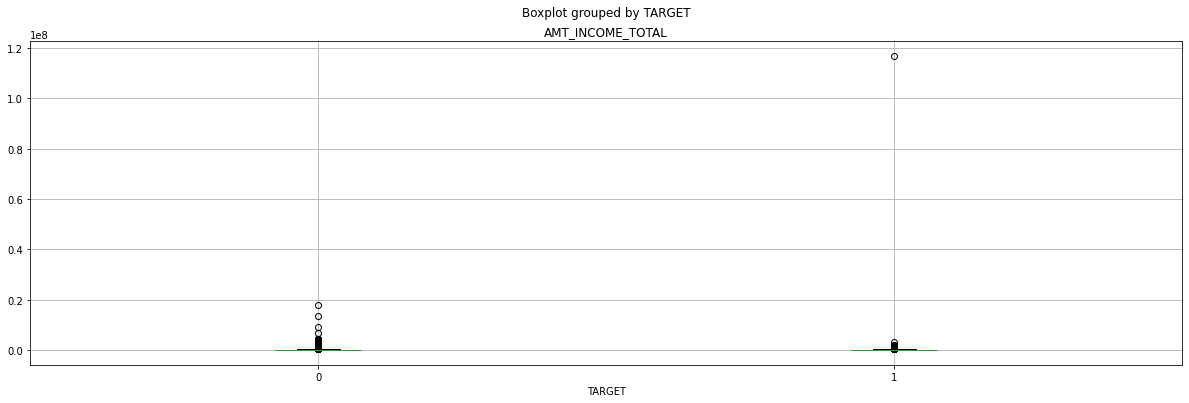

0.9000     270000.0
0.9500     337500.0
0.9999    2250000.0
Name: AMT_INCOME_TOTAL, dtype: float64

In [76]:
df_ca_capacity.boxplot(column='AMT_INCOME_TOTAL', by='TARGET', figsize = (20, 6));plt.show()
df_ca_capacity.quantile([0.9, 0.95, .9999])['AMT_INCOME_TOTAL']

- The boxplot shows that most of the incomes lie in a small range. While a few are extremely high. 
- The spread is very skewed. So bin the income groups
- Are there any particular income groups that struggle to pay back loans? or pay comfortably?

In [77]:
print(df_ca_capacity[['AMT_INCOME_TOTAL']].quantile([0, 0.25, 0.5, 0.75, 1])['AMT_INCOME_TOTAL'].to_list())

[25650.0, 112500.0, 147150.0, 202500.0, 117000000.0]


Max income is 117000000 which is way higher than the rest. Let's investigate this data point in depth

In [78]:
df_ca_maxincome = df_ca.iloc[df_ca['AMT_INCOME_TOTAL'].idxmax()][['SK_ID_CURR','AMT_INCOME_TOTAL'] + CA_CLIENT_COLS ]
df_ca_maxincome[CA_CLIENT_COLS]
print("Age of the client with highest income", 12615/365)

Age of the client with highest income 34.56164383561644


Age of the client with highest income is 34 years!! 

In [79]:
print(df_ca_capacity[['AMT_INCOME_TOTAL']].mean(), df_ca_capacity[['AMT_INCOME_TOTAL']].median())
print(df_ca_capacity[['AMT_INCOME_TOTAL']].quantile([0, 0.00005, 0.0005, 0.005, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99999, 1]))

AMT_INCOME_TOTAL    168797.919297
dtype: float64 AMT_INCOME_TOTAL    147150.0
dtype: float64
         AMT_INCOME_TOTAL
0.00000      2.565000e+04
0.00005      2.700000e+04
0.00050      3.083782e+04
0.00500      4.500000e+04
0.05000      6.750000e+04
0.10000      8.100000e+04
0.25000      1.125000e+05
0.50000      1.471500e+05
0.75000      2.025000e+05
0.90000      2.700000e+05
0.99999      8.831025e+06
1.00000      1.170000e+08


In [80]:
print(getIQR(df_ca_capacity,'AMT_INCOME_TOTAL'), getMaxScore(df_ca,'AMT_INCOME_TOTAL'))

90000.0 337500.0


Bin the AMT_INCOME_TOTAL into smaller groups

<50K      4517
<1L      59181
<10L    243563
<50L       245
>50L         5
Name: INCOME_GROUP, dtype: int64
df_1: 24825, df_0: 282686
               Total  Target=1  Target=0  Target=1%  Target=0%
INCOME_GROUP                                                  
<50K            4517       343      4174       7.59      92.41
<1L            59181      4882     54299       8.25      91.75
<10L          243563     19587    223976       8.04      91.96
<50L             245        12       233       4.90      95.10
>50L               5         1         4      20.00      80.00


<Figure size 800x800 with 0 Axes>

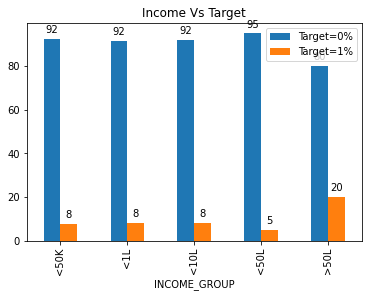

Total  Target=1  Target=0  Target=1%  Target=0%
INCOME_GROUP                                                  
<50K            4517       343      4174       7.59      92.41
<1L            59181      4882     54299       8.25      91.75
<10L          243563     19587    223976       8.04      91.96
<50L             245        12       233       4.90      95.10
>50L               5         1         4      20.00      80.00

In [81]:
df_ca_copy = df_ca_capacity.copy()
df_ca_capacity['INCOME_GROUP'] = pd.cut(df_ca_capacity['AMT_INCOME_TOTAL'], [0, 50000, 100000, 1000000, 5000000, 200000000], labels=['<50K', '<1L', '<10L', '<50L', '>50L'])
income_groups = df_ca_capacity['INCOME_GROUP'].value_counts(sort=False)
print(income_groups)

# Group the income bins based on TARGET
df_ca_income = groupPerTarget(df_ca_capacity, 'INCOME_GROUP')
plotBar(df_ca_income[['Target=0%','Target=1%']], "Income Vs Target")
df_ca_income

Clients from the >50L income group seem to be having difficulties in paying the loan

In [82]:
df_ca_capacity.iloc[df_ca_capacity['AMT_INCOME_TOTAL'].idxmax()][['SK_ID_CURR','AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE']] # + CA_CLIENT_COLUMNS ]

SK_ID_CURR                 114967
AMT_INCOME_TOTAL      117000000.0
AMT_CREDIT               562491.0
AMT_GOODS_PRICE     502762.781552
Name: 12840, dtype: object

In [83]:
id, income, credit, goods_price = df_ca_capacity.iloc[df_ca_capacity['AMT_INCOME_TOTAL'].idxmax()][['SK_ID_CURR','AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE']].to_list()
print(id, income, credit, goods_price, percent(credit, income))

114967 117000000.0 562491.0 502762.78155166254 0.48


Max income value is 11 crores. Goods price is 4.5L and credit value is 5.6 L. The loan amount is < 1% of the income which seems bizzare. This can be removed.

In [84]:
df_ca_capacity_red = df_ca_capacity[df_ca_capacity['AMT_INCOME_TOTAL'] < getMaxScore(df_ca_capacity,'AMT_INCOME_TOTAL')]
print(df_ca_capacity.shape[0], df_ca_capacity_red.shape[0])

307511 291686


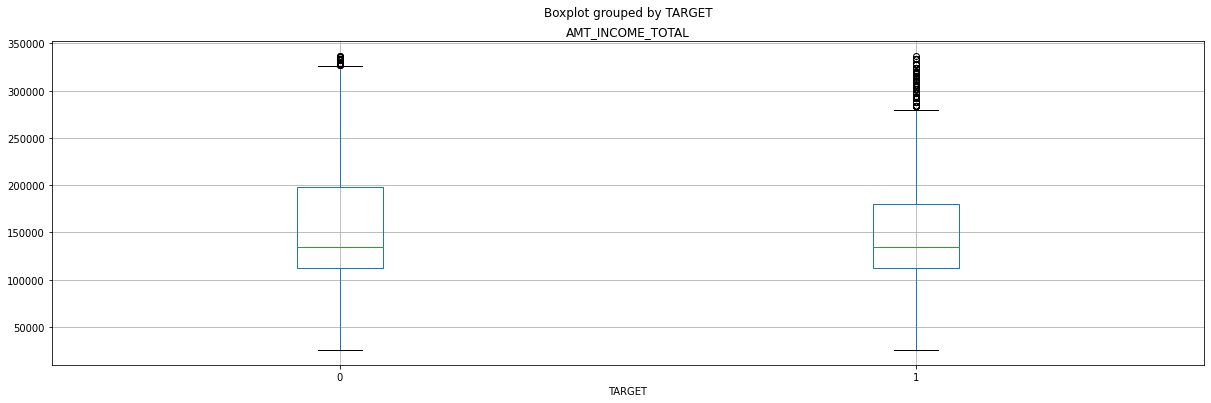

In [85]:
# Outliers - box plot
df_ca_capacity_red.boxplot(column='AMT_INCOME_TOTAL', by='TARGET', figsize = (20, 6)); plt.show()

### DEBT_TO_INCOME

Calculate the debt-to-income ratio

In [86]:
df_ca_capacity['DEBT_TO_INCOME'] = percent(df_ca_capacity['AMT_ANNUITY'], df_ca_capacity['AMT_INCOME_TOTAL'])
print(df_ca_capacity[(df_ca_capacity['DEBT_TO_INCOME'] > 35) & (df_ca_capacity['TARGET'] == 1) ][['DEBT_TO_INCOME', 'TARGET']])
print(df_ca_capacity[(df_ca_capacity['DEBT_TO_INCOME'] > 35) & (df_ca_capacity['TARGET'] == 0) ][['DEBT_TO_INCOME', 'TARGET']])

        DEBT_TO_INCOME  TARGET
26               43.56       1
235              54.29       1
283              39.50       1
550              35.62       1
586              35.94       1
...                ...     ...
307082           35.62       1
307323           38.30       1
307363          113.35       1
307438           42.01       1
307475           45.25       1

[2633 rows x 2 columns]
        DEBT_TO_INCOME  TARGET
6                45.64       0
8                45.32       0
34               41.67       0
48               51.72       0
54               41.67       0
...                ...     ...
307476           65.26       0
307480           83.33       0
307487           45.81       0
307491           59.90       0
307493           35.07       0

[34387 rows x 2 columns]


In [87]:
# Update df_final for corelation analysis
df_final = df_final.merge(df_ca_capacity[['DEBT_TO_INCOME', 'SK_ID_CURR']], how='inner', on='SK_ID_CURR')
print(df_final.shape, df_final.columns)

(307504, 21) Index(['CODE_GENDER', 'DAYS_BIRTH', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'REGION_RATING_CLIENT_W_CITY', 'SK_ID_CURR', 'TARGET', 'AGE',
       'PA_STATUS', 'PrevApps', 'Total Prev Apps', 'Approved', 'Canceled',
       'Refused', 'Unused offer', 'ENQUIRIES_CREDIT_BUREAU',
       'DEF_PC_SOCIAL_CIRCLE', 'DEBT_TO_INCOME'],
      dtype='object')


<AxesSubplot:title={'center':'DEBT_TO_INCOME'}, xlabel='TARGET'>

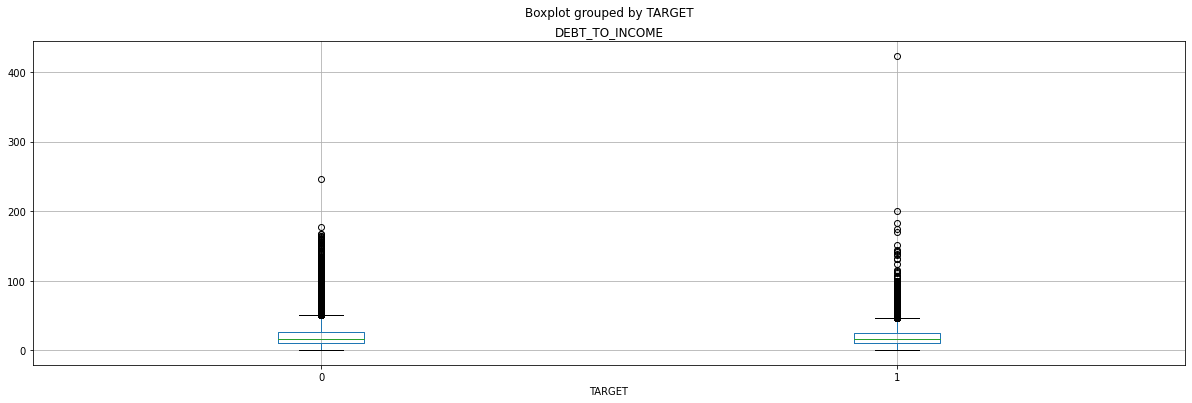

In [88]:
df_ca_capacity.boxplot(column='DEBT_TO_INCOME', by='TARGET', figsize = (20, 6))

There is not much difference in the spread of Debt-to-income ratio for TARGET=0 & TARGET=1. 

### Income, Credit, Goods

In [89]:
df_ca_capacity.iloc[df_ca_capacity['AMT_INCOME_TOTAL'].idxmax()][['SK_ID_CURR','AMT_INCOME_TOTAL']]

SK_ID_CURR               114967
AMT_INCOME_TOTAL    117000000.0
Name: 12840, dtype: object

In [90]:
df_ca_capacity_red = df_ca_capacity[df_ca_capacity['SK_ID_CURR'] != 114967]
print(df_ca_capacity.shape[0], df_ca_capacity_red.shape[0])

307511 307510


In [91]:
df_ca_capacity_red.columns

Index(['AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 'AMT_ANNUITY',
       'SK_ID_CURR', 'TARGET', 'DAYS_EMPLOYED', 'INCOME_GROUP',
       'DEBT_TO_INCOME'],
      dtype='object')

In [92]:
# Update df_final for corelation analysis
df_final = df_final.merge(df_ca_capacity_red[['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE',
                                            'AMT_CREDIT', 'AMT_ANNUITY']], how='inner', on='SK_ID_CURR')
print(df_final.shape, df_final.columns)

(307503, 25) Index(['CODE_GENDER', 'DAYS_BIRTH', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'REGION_RATING_CLIENT_W_CITY', 'SK_ID_CURR', 'TARGET', 'AGE',
       'PA_STATUS', 'PrevApps', 'Total Prev Apps', 'Approved', 'Canceled',
       'Refused', 'Unused offer', 'ENQUIRIES_CREDIT_BUREAU',
       'DEF_PC_SOCIAL_CIRCLE', 'DEBT_TO_INCOME', 'AMT_INCOME_TOTAL',
       'AMT_GOODS_PRICE', 'AMT_CREDIT', 'AMT_ANNUITY'],
      dtype='object')


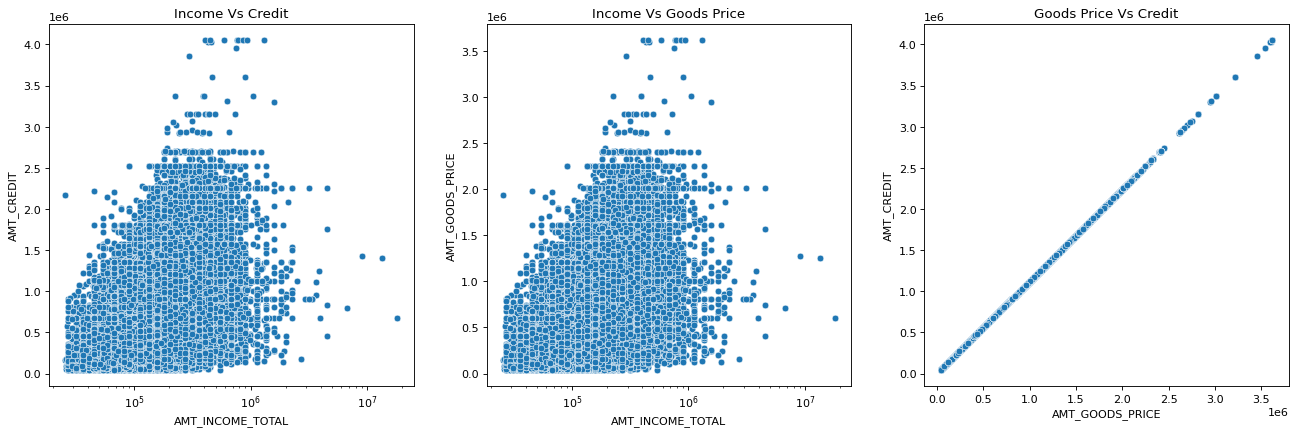

In [93]:
plt.figure(figsize=(20, 6), dpi=80)
plt.subplot(1, 3, 1)
ax = sns.scatterplot(df_ca_capacity_red['AMT_INCOME_TOTAL'], df_ca_capacity_red['AMT_CREDIT']); ax.set_xscale('log'); ax.set_title("Income Vs Credit")
plt.subplot(1, 3, 2)
ax = sns.scatterplot(df_ca_capacity_red['AMT_INCOME_TOTAL'], df_ca_capacity_red['AMT_GOODS_PRICE']); ax.set_xscale('log'); ax.set_title("Income Vs Goods Price")
plt.subplot(1, 3, 3)
ax = sns.scatterplot(df_ca_capacity_red['AMT_GOODS_PRICE'], df_ca_capacity_red['AMT_CREDIT']); ax.set_title("Goods Price Vs Credit")
plt.show()

# TODO: How to get the outliers? 

- Strong +ve correlation between AMT_GOODS_PRICE & AMT_CREDIT
- Small correlation between AMT_INCOME_TOTAL & AMT_GOODS_PRICE & AMT_CREDIT

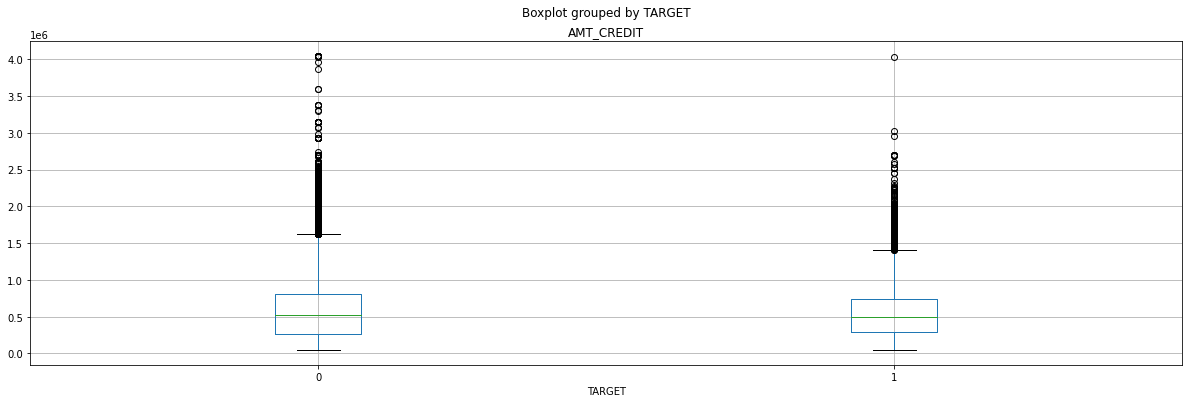

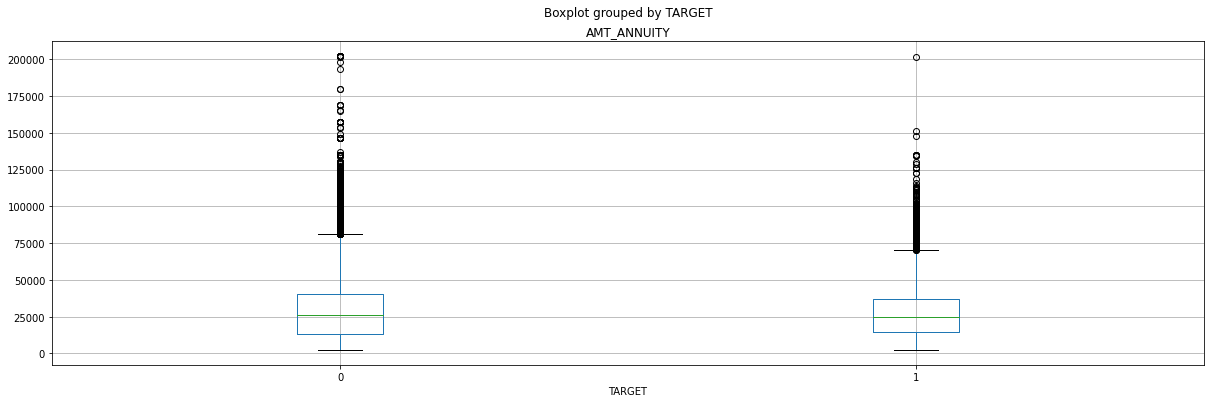

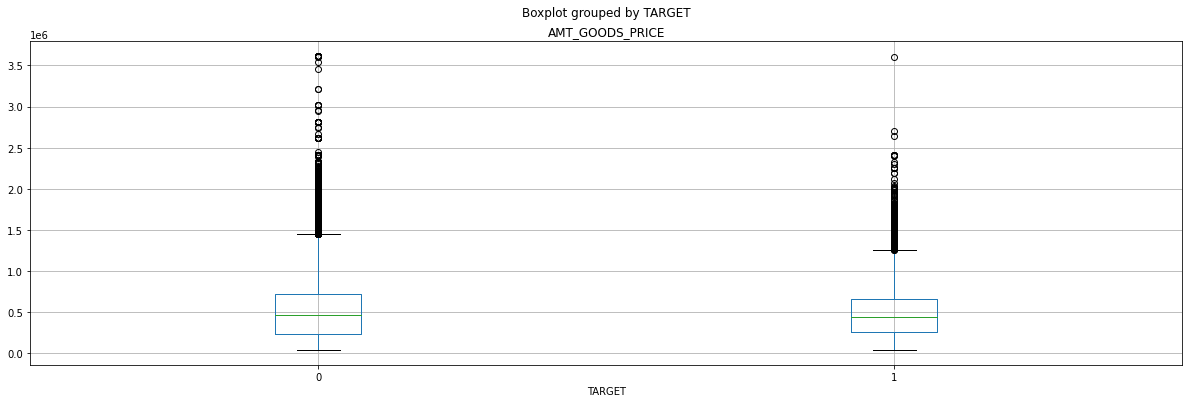

In [94]:
for col in ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']:
    df_ca_capacity_red.boxplot(column=col, by='TARGET', figsize = (20, 6))

There is not much difference in the spread of AMT* for TARGET=0 & TARGET=1. 

### **OBSERVATIONS**
| COLUMN(S) | Outliers? | Observation | Difficulties in paying | No difficulties in paying | 
|---|---|---|---|---|
| INCOME | None | None | Clients from the >50L income group seem to be having difficulties in paying the loan | None |
| DEBT-TO-INCOME | None  | This does not affect the client's ability to pay |  |  |
| AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE | NA | Independently these does not affect the client's ability to pay |  |  |


## 5. ANALYSIS: **Capital**
Amount of money an applicant has
- Car, Realty

In [95]:
print(df_ca[df_ca['FLAG_OWN_REALTY'] == 'Y'][['SK_ID_CURR','NAME_HOUSING_TYPE']].sort_values(by='NAME_HOUSING_TYPE', ascending=False))
print(df_ca[ (df_ca['FLAG_OWN_REALTY'] == 'N') & (~ df_ca['NAME_HOUSING_TYPE'].isna()) ][['SK_ID_CURR','FLAG_OWN_REALTY', 'NAME_HOUSING_TYPE']])

        SK_ID_CURR NAME_HOUSING_TYPE
109770      227307      With parents
187636      317517      With parents
35122       140686      With parents
253378      393196      With parents
35128       140692      With parents
...            ...               ...
11779       113727   Co-op apartment
287090      432533   Co-op apartment
162552      288444   Co-op apartment
137125      259040   Co-op apartment
84930       198531   Co-op apartment

[213312 rows x 2 columns]
        SK_ID_CURR FLAG_OWN_REALTY  NAME_HOUSING_TYPE
1           100003               N  House / apartment
13          100017               N  House / apartment
16          100020               N  House / apartment
22          100026               N   Rented apartment
24          100029               N  House / apartment
...            ...             ...                ...
307494      456238               N  House / apartment
307495      456239               N  House / apartment
307496      456240               N  House /

df_1: 24825, df_0: 282686
               Total  Target=1  Target=0  Target=1%  Target=0%
FLAG_OWN_CAR                                                  
N             202924     17249    185675       8.50      91.50
Y             104587      7576     97011       7.24      92.76


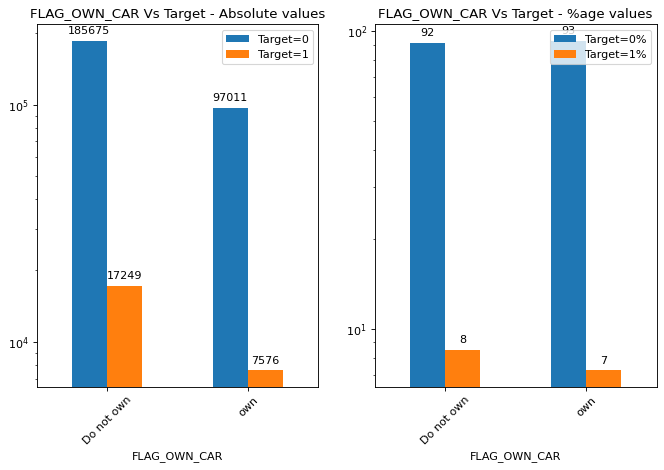

df_1: 24825, df_0: 282686
                  Total  Target=1  Target=0  Target=1%  Target=0%
FLAG_OWN_REALTY                                                  
N                 94199      7842     86357       8.32      91.68
Y                213312     16983    196329       7.96      92.04


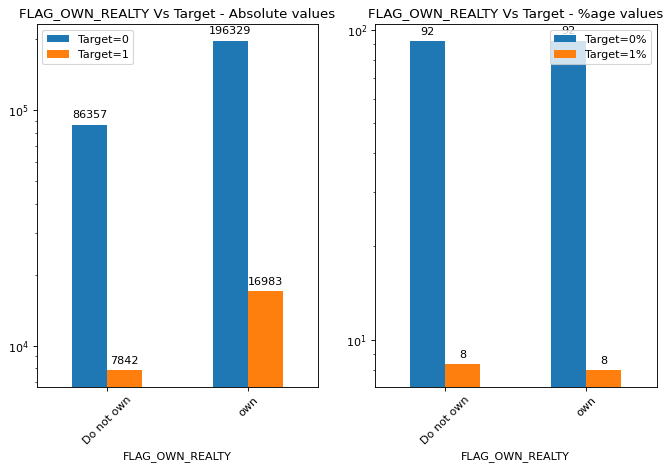

In [96]:
for col in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df_= plotTargetWiseBarPlots(df_ca, col, col, labels =["Do not own", "own"])

### **OBSERVATIONS**
| COLUMN(S) | Outliers? | Observation | Difficulties in paying | No difficulties in paying | 
|---|---|---|---|---|
| INCOME | None | This does not affect the client's ability to pay | None | None|

## 6.ANALYSIS: **Application**
Information provided in the application
- Who accompanied the applicant
- Details provided - phone, email, address
- Documents submitted
- Day & time of the application

In [97]:
CA_APP_FLAG_COLS = ['FLAG_MOBIL','FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']
CA_APP_APPR_PROCESS_START_COLS = ['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START']
CA_APP_REGION_COLS = ['REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']
CA_APP_DAYS_COLS = ['DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']

In [98]:
df_ca_app = getCategoryDf(df_ca, CA_APPLICATION_COLS)
getGeneralInfo(df_ca_app)

Shape: (307511, 39)

Columns: ['NAME_TYPE_SUITE', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'SK_ID_CURR', 'TARGET']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 39 columns):
 #   Column                       Non-Null Count   Dtype

There are too many FLAG_DOCUMENT* & FLAG_* columns. Add all the FLAG_DOCUMENT* columns into 
- FLAG_DOCUMENT column - Number of documents submitted 
- FLAG_CONTACT column - Number of phone/mobile/email contact details submitted

In [99]:
# FLAG_DOCUMENTS: Number of documents submitted 
df_ca_app['FLAG_DOCUMENT'] = functools.reduce(lambda a, b: a+b, [df_ca_app[col] for col in CA_FLAG_DOCUMENT_COLS])
print(df_ca_app['FLAG_DOCUMENT'].describe())
print(df_ca_app['FLAG_DOCUMENT'].value_counts())
dropColumns(df_ca_app, "CA_FLAG_DOCUMENT_COLS", CA_FLAG_DOCUMENT_COLS)

df_ca_app['FLAG_CONTACT'] = 0 
print(df_ca_app[CA_APP_FLAG_COLS + ['FLAG_CONTACT']].head())

df_ca_app['FLAG_CONTACT'] = functools.reduce(lambda a, b: a+b, [df_ca_app[col] for col in CA_APP_FLAG_COLS])
'''
for col in CA_APP_FLAG_COLS:
    df_ca_app['FLAG_CONTACT'] += df_ca_app[col]
'''

print(df_ca_app[CA_APP_FLAG_COLS + ['FLAG_CONTACT']].head())

count    307511.000000
mean          0.930155
std           0.344295
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: FLAG_DOCUMENT, dtype: float64
1    270056
0     29549
2      7742
3       163
4         1
Name: FLAG_DOCUMENT, dtype: int64
Drop CA_FLAG_DOCUMENT_COLS 20 columns: Shape - before (307511, 40) Shape - after (307511, 20)
   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  \
0           1               1                0           1           0   
1           1               1                0           1           0   
2           1               1                1           1           0   
3           1               1                0           0           0   
4           1               1                0           0           0   

   FLAG_CONTACT  
0             0  
1             0  
2             0  
3             0  
4             0  
   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WOR

In [100]:
df_ca_app.columns

Index(['NAME_TYPE_SUITE', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'SK_ID_CURR',
       'TARGET', 'FLAG_DOCUMENT', 'FLAG_CONTACT'],
      dtype='object')

In [101]:
# FLAG_CONT_MOBILE - Was phone reachable?

Convert the DAYS* to YEARS

In [102]:
df_ca_app[['DAYS_REGISTRATION','DAYS_ID_PUBLISH']].describe()
df_ca_app['YEARS_REGISTRATION'] = df_ca_app['DAYS_REGISTRATION']*(-1); df_ca_app['YEARS_REGISTRATION'] = (df_ca_app['YEARS_REGISTRATION']/365)
df_ca_app['YEARS_ID_PUBLISH'] = df_ca_app['DAYS_ID_PUBLISH']*(-1); df_ca_app['YEARS_ID_PUBLISH'] = (df_ca_app['YEARS_ID_PUBLISH']/365)
print(df_ca_app[['YEARS_REGISTRATION', 'YEARS_ID_PUBLISH']].describe())

       YEARS_REGISTRATION  YEARS_ID_PUBLISH
count       307511.000000     307511.000000
mean            13.660604          8.203294
std              9.651743          4.135481
min             -0.000000          0.000000
25%              5.506849          4.712329
50%             12.339726          8.915068
75%             20.491781         11.778082
max             67.594521         19.717808


In [103]:
# Update df_final for corelation analysis
df_final = df_final.merge(df_ca_app[['YEARS_REGISTRATION', 'YEARS_ID_PUBLISH', 'SK_ID_CURR']], how='inner', on='SK_ID_CURR')
print(df_final.shape, df_final.columns)

(307503, 27) Index(['CODE_GENDER', 'DAYS_BIRTH', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'REGION_RATING_CLIENT_W_CITY', 'SK_ID_CURR', 'TARGET', 'AGE',
       'PA_STATUS', 'PrevApps', 'Total Prev Apps', 'Approved', 'Canceled',
       'Refused', 'Unused offer', 'ENQUIRIES_CREDIT_BUREAU',
       'DEF_PC_SOCIAL_CIRCLE', 'DEBT_TO_INCOME', 'AMT_INCOME_TOTAL',
       'AMT_GOODS_PRICE', 'AMT_CREDIT', 'AMT_ANNUITY', 'YEARS_REGISTRATION',
       'YEARS_ID_PUBLISH'],
      dtype='object')


YEARS_REGISTRATION


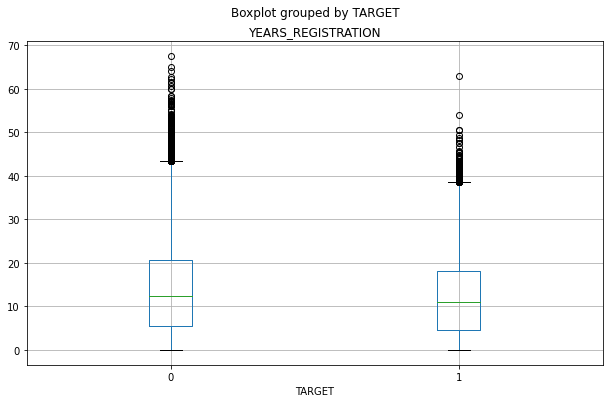

YEARS_ID_PUBLISH


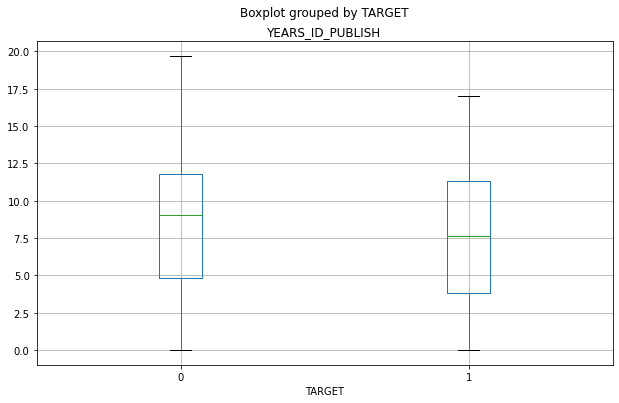

In [104]:
# Check for outliers
for col in ['YEARS_REGISTRATION', 'YEARS_ID_PUBLISH']: 
    print(col)
    df_ca_app.boxplot(column=col, by='TARGET', figsize = (10, 6))
    plt.show()

df_1: 24825, df_0: 282686
                  Total  Target=1  Target=0  Target=1%  Target=0%
NAME_TYPE_SUITE                                                  
Children           3267       241      3026       7.38      92.62
Family            40149      3009     37140       7.49      92.51
Group of people     271        23       248       8.49      91.51
Other_A             866        76       790       8.78      91.22
Other_B            1770       174      1596       9.83      90.17
Spouse, partner   11370       895     10475       7.87      92.13
Unaccompanied    248526     20337    228189       8.18      91.82


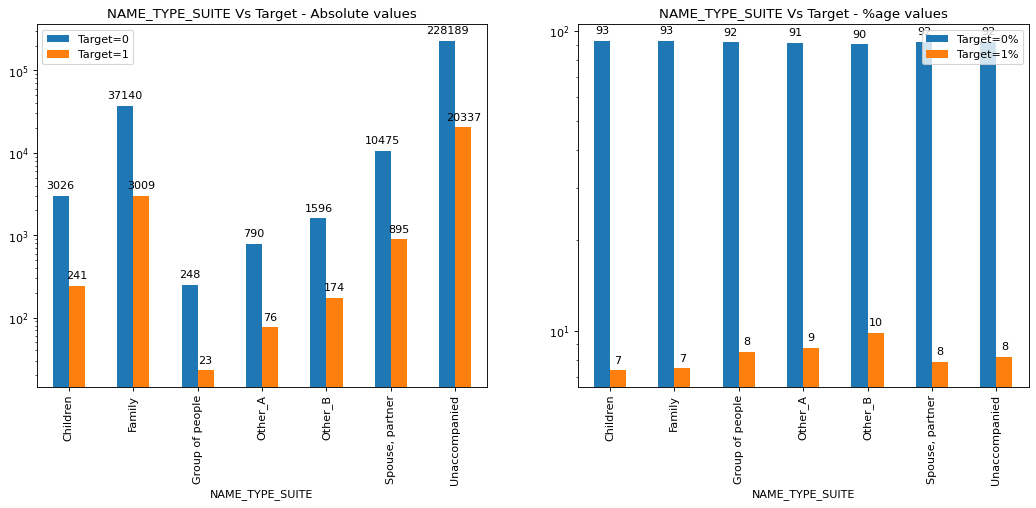

df_1: 24825, df_0: 282686
                   Total  Target=1  Target=0  Target=1%  Target=0%
FLAG_CONT_MOBILE                                                  
0                    574        45       529       7.84      92.16
1                 306937     24780    282157       8.07      91.93


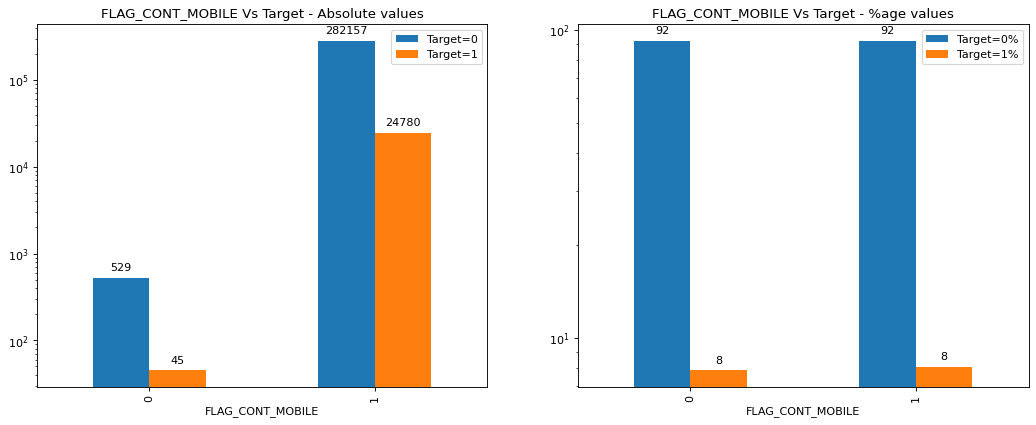

df_1: 24825, df_0: 282686
               Total  Target=1  Target=0  Target=1%  Target=0%
FLAG_MOBIL                                                    
0                1.0       0.0         1       0.00     100.00
1           307510.0   24825.0    282685       8.07      91.93


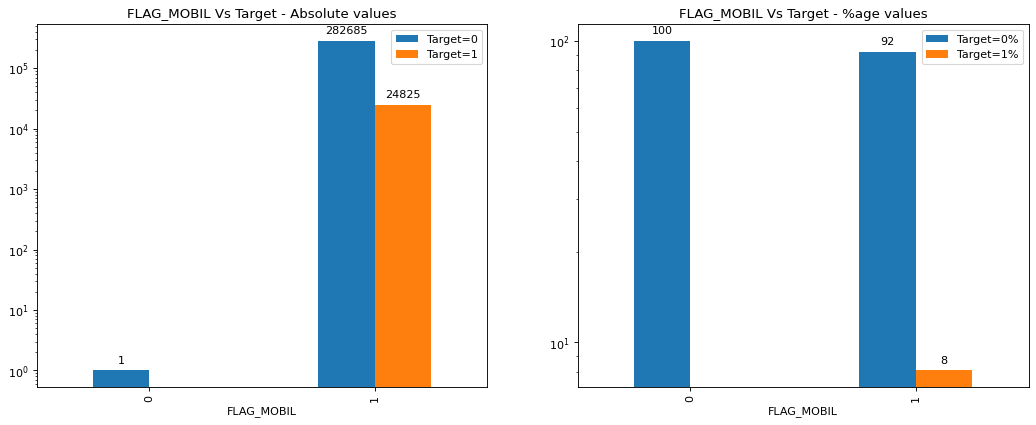

df_1: 24825, df_0: 282686
                 Total  Target=1  Target=0  Target=1%  Target=0%
FLAG_EMP_PHONE                                                  
0                55386      2991     52395       5.40      94.60
1               252125     21834    230291       8.66      91.34


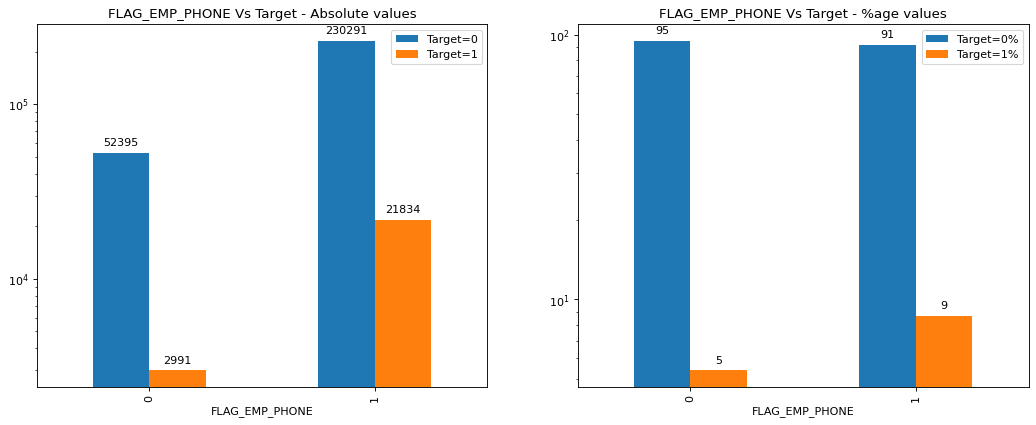

df_1: 24825, df_0: 282686
                  Total  Target=1  Target=0  Target=1%  Target=0%
FLAG_WORK_PHONE                                                  
0                246203     18921    227282       7.69      92.31
1                 61308      5904     55404       9.63      90.37


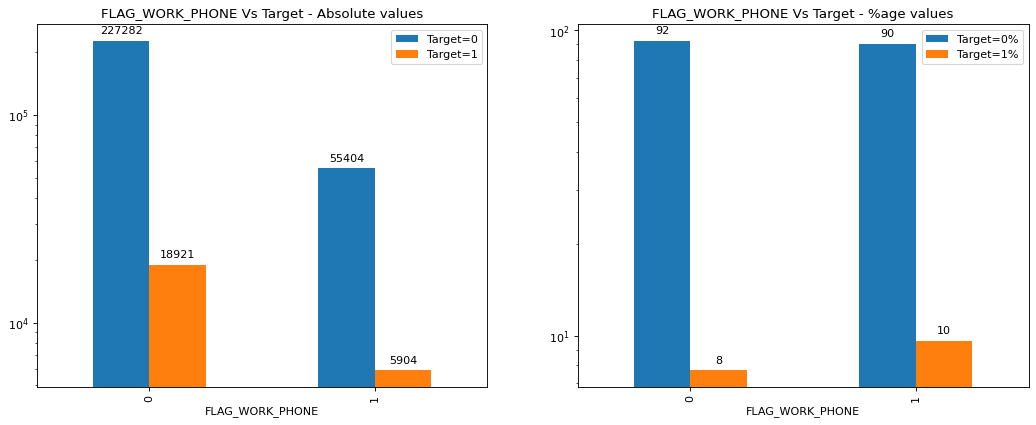

df_1: 24825, df_0: 282686
             Total  Target=1  Target=0  Target=1%  Target=0%
FLAG_PHONE                                                  
0           221080     18744    202336       8.48      91.52
1            86431      6081     80350       7.04      92.96


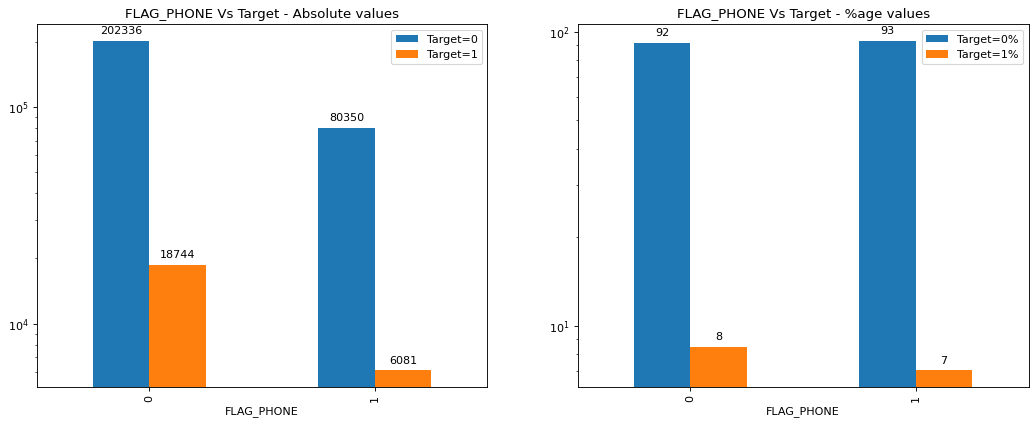

df_1: 24825, df_0: 282686
             Total  Target=1  Target=0  Target=1%  Target=0%
FLAG_EMAIL                                                  
0           290069     23451    266618       8.08      91.92
1            17442      1374     16068       7.88      92.12


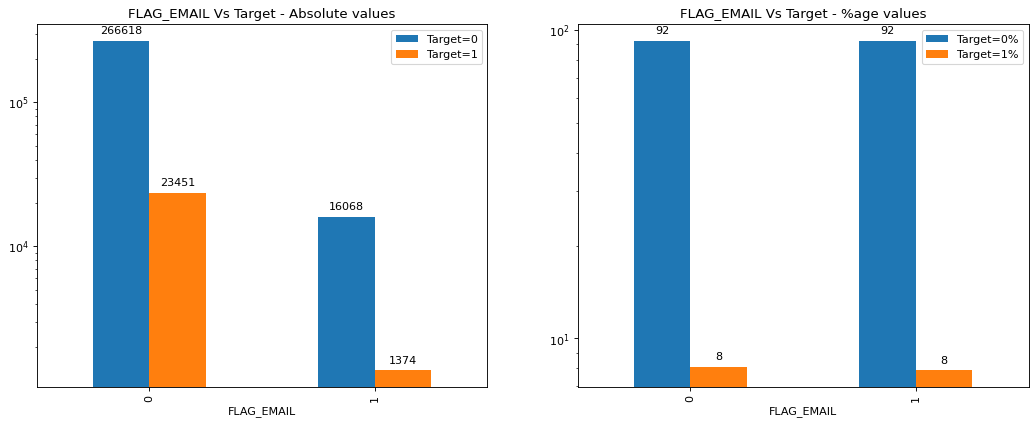

df_1: 24825, df_0: 282686
                            Total  Target=1  Target=0  Target=1%  Target=0%
WEEKDAY_APPR_PROCESS_START                                                 
FRIDAY                      50338      4101     46237       8.15      91.85
MONDAY                      50714      3934     46780       7.76      92.24
SATURDAY                    33852      2670     31182       7.89      92.11
SUNDAY                      16181      1283     14898       7.93      92.07
THURSDAY                    50591      4098     46493       8.10      91.90
TUESDAY                     53901      4501     49400       8.35      91.65
WEDNESDAY                   51934      4238     47696       8.16      91.84


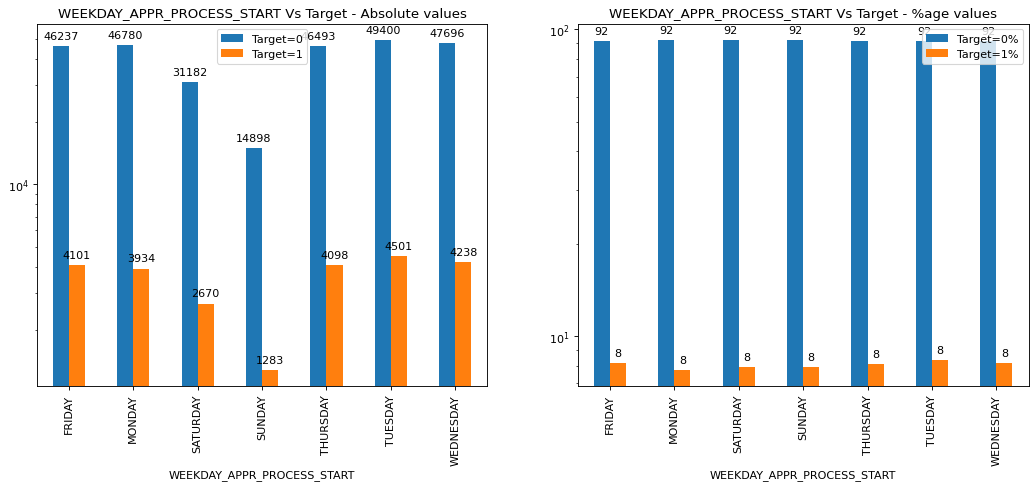

df_1: 24825, df_0: 282686
                         Total  Target=1  Target=0  Target=1%  Target=0%
HOUR_APPR_PROCESS_START                                                 
0                           40         6        34      15.00      85.00
1                           86         7        79       8.14      91.86
2                          305        30       275       9.84      90.16
3                         1230       107      1123       8.70      91.30
4                         2090       173      1917       8.28      91.72
5                         3638       385      3253      10.58      89.42
6                         5842       645      5197      11.04      88.96
7                         9131       917      8214      10.04      89.96
8                        15127      1373     13754       9.08      90.92
9                        27384      2247     25137       8.21      91.79
10                       37722      3026     34696       8.02      91.98
11                       

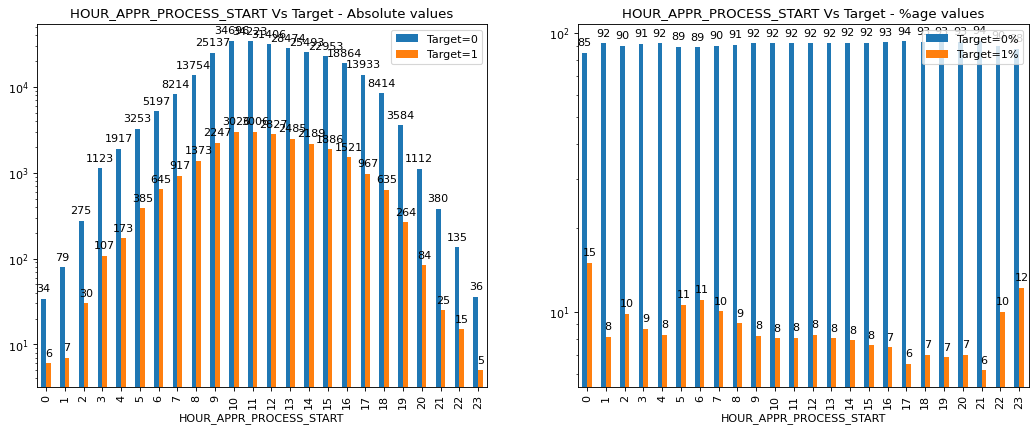

df_1: 24825, df_0: 282686
                             Total  Target=1  Target=0  Target=1%  Target=0%
REG_REGION_NOT_LIVE_REGION                                                  
0                           302854     24392    278462       8.05      91.95
1                             4657       433      4224       9.30      90.70


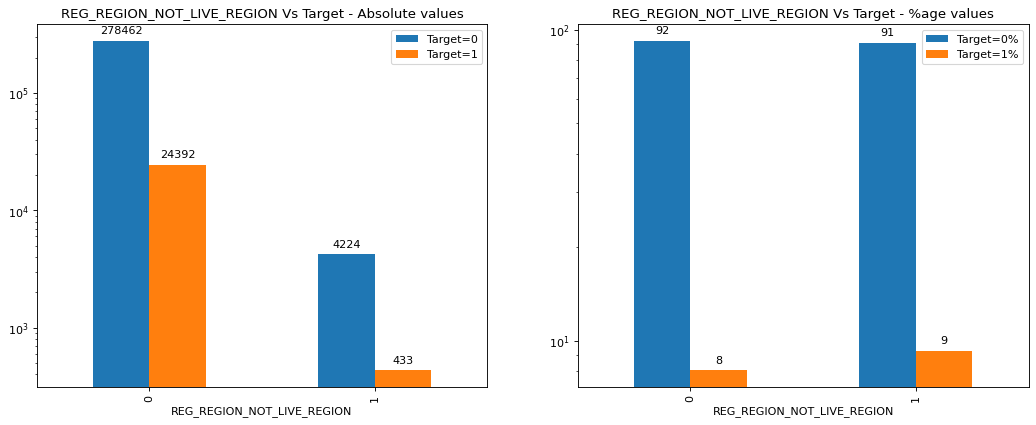

df_1: 24825, df_0: 282686
                             Total  Target=1  Target=0  Target=1%  Target=0%
REG_REGION_NOT_WORK_REGION                                                  
0                           291899     23437    268462       8.03      91.97
1                            15612      1388     14224       8.89      91.11


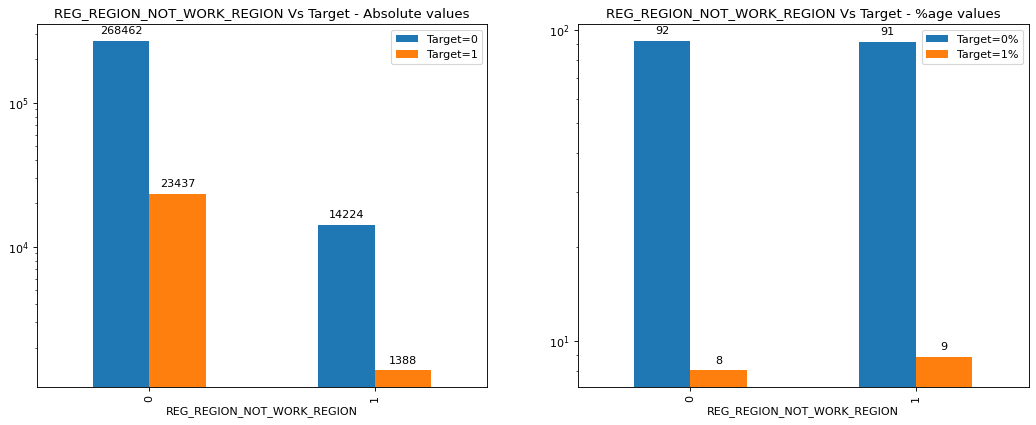

df_1: 24825, df_0: 282686
                              Total  Target=1  Target=0  Target=1%  Target=0%
LIVE_REGION_NOT_WORK_REGION                                                  
0                            295008     23769    271239       8.06      91.94
1                             12503      1056     11447       8.45      91.55


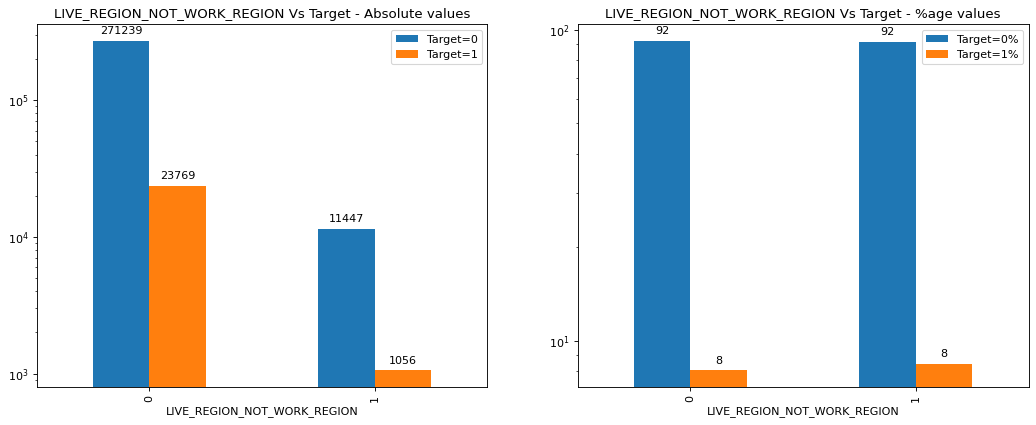

df_1: 24825, df_0: 282686
                         Total  Target=1  Target=0  Target=1%  Target=0%
REG_CITY_NOT_LIVE_CITY                                                  
0                       283472     21886    261586       7.72      92.28
1                        24039      2939     21100      12.23      87.77


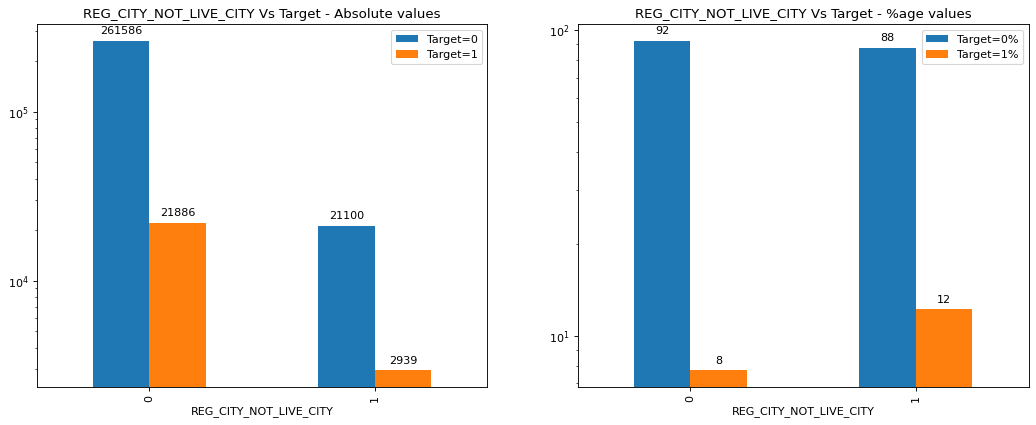

df_1: 24825, df_0: 282686
                         Total  Target=1  Target=0  Target=1%  Target=0%
REG_CITY_NOT_WORK_CITY                                                  
0                       236644     17305    219339       7.31      92.69
1                        70867      7520     63347      10.61      89.39


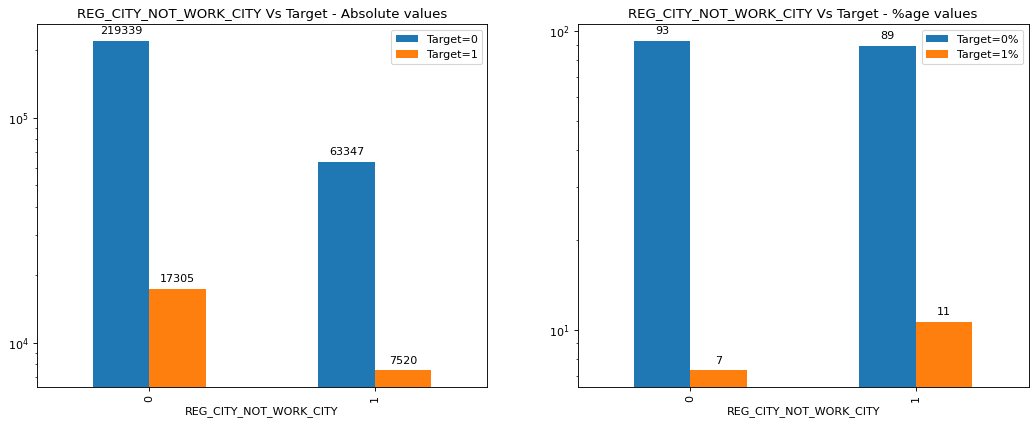

df_1: 24825, df_0: 282686
                          Total  Target=1  Target=0  Target=1%  Target=0%
LIVE_CITY_NOT_WORK_CITY                                                  
0                        252296     19322    232974       7.66      92.34
1                         55215      5503     49712       9.97      90.03


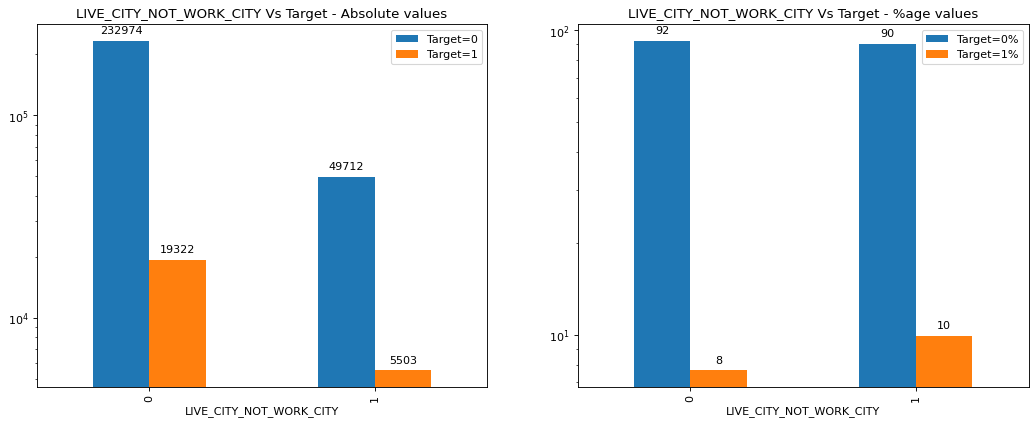

In [105]:
CA_APP_CAT_COLS = ['NAME_TYPE_SUITE','FLAG_CONT_MOBILE'] + CA_APP_FLAG_COLS + CA_APP_APPR_PROCESS_START_COLS + CA_APP_REGION_COLS

for col in CA_APP_CAT_COLS: 
    plotTargetWiseBarPlots(df_ca_app, col, col, figsize=(16, 6))

- Clients who applied around midnight have difficulties in paying

#### OBSERVATIONS


## **CORRELATION** 

In [109]:
print(df_final.shape, df_final.columns)

(307503, 27) Index(['CODE_GENDER', 'DAYS_BIRTH', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'REGION_RATING_CLIENT_W_CITY', 'SK_ID_CURR', 'TARGET', 'AGE',
       'PA_STATUS', 'PrevApps', 'Total Prev Apps', 'Approved', 'Canceled',
       'Refused', 'Unused offer', 'ENQUIRIES_CREDIT_BUREAU',
       'DEF_PC_SOCIAL_CIRCLE', 'DEBT_TO_INCOME', 'AMT_INCOME_TOTAL',
       'AMT_GOODS_PRICE', 'AMT_CREDIT', 'AMT_ANNUITY', 'YEARS_REGISTRATION',
       'YEARS_ID_PUBLISH'],
      dtype='object')


Index(['NAME_FAMILY_STATUS', 'CODE_GENDER', 'Total Prev Apps', 'PA_STATUS',
       'AMT_CREDIT', 'YEARS_ID_PUBLISH', 'DAYS_BIRTH',
       'REGION_POPULATION_RELATIVE', 'Refused', 'DEBT_TO_INCOME',
       'ENQUIRIES_CREDIT_BUREAU', 'AMT_ANNUITY', 'NAME_HOUSING_TYPE',
       'CNT_FAM_MEMBERS', 'Approved', 'REGION_RATING_CLIENT_W_CITY',
       'DEF_PC_SOCIAL_CIRCLE', 'YEARS_REGISTRATION', 'CNT_CHILDREN',
       'Canceled', 'AGE', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL'],
      dtype='object') (24824, 23)
TOP 10 CORRELATIONS for TARGET=0
          Variable1        Variable2  CORR
0        AMT_CREDIT  AMT_GOODS_PRICE  1.00
19      AMT_ANNUITY  AMT_GOODS_PRICE  1.00
21      AMT_ANNUITY       AMT_CREDIT  1.00
23     CNT_CHILDREN  CNT_FAM_MEMBERS  0.89
25          Refused  Total Prev Apps  0.74
27  Total Prev Apps         Approved  0.71
29         Canceled  Total Prev Apps  0.67
31       AMT_CREDIT   DEBT_TO_INCOME  0.64
33   DEBT_TO_INCOME  AMT_GOODS_PRICE  0.64
35   DEBT_TO_INCOME      AMT_ANN

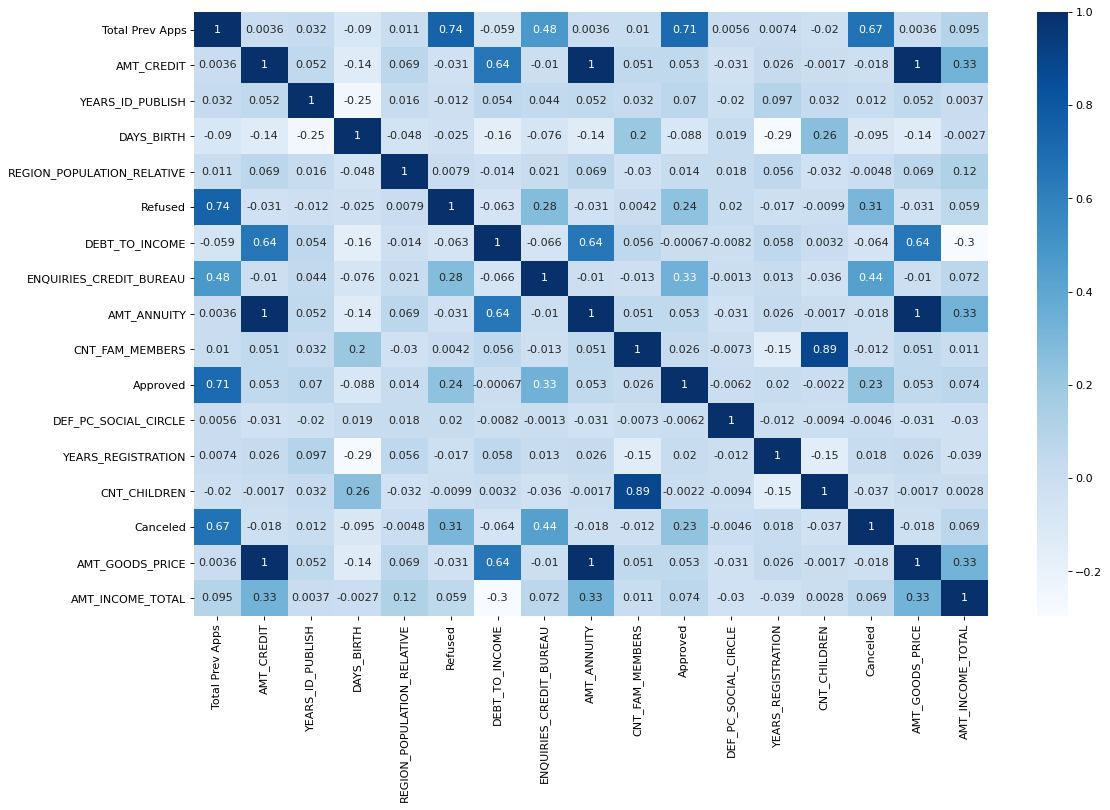

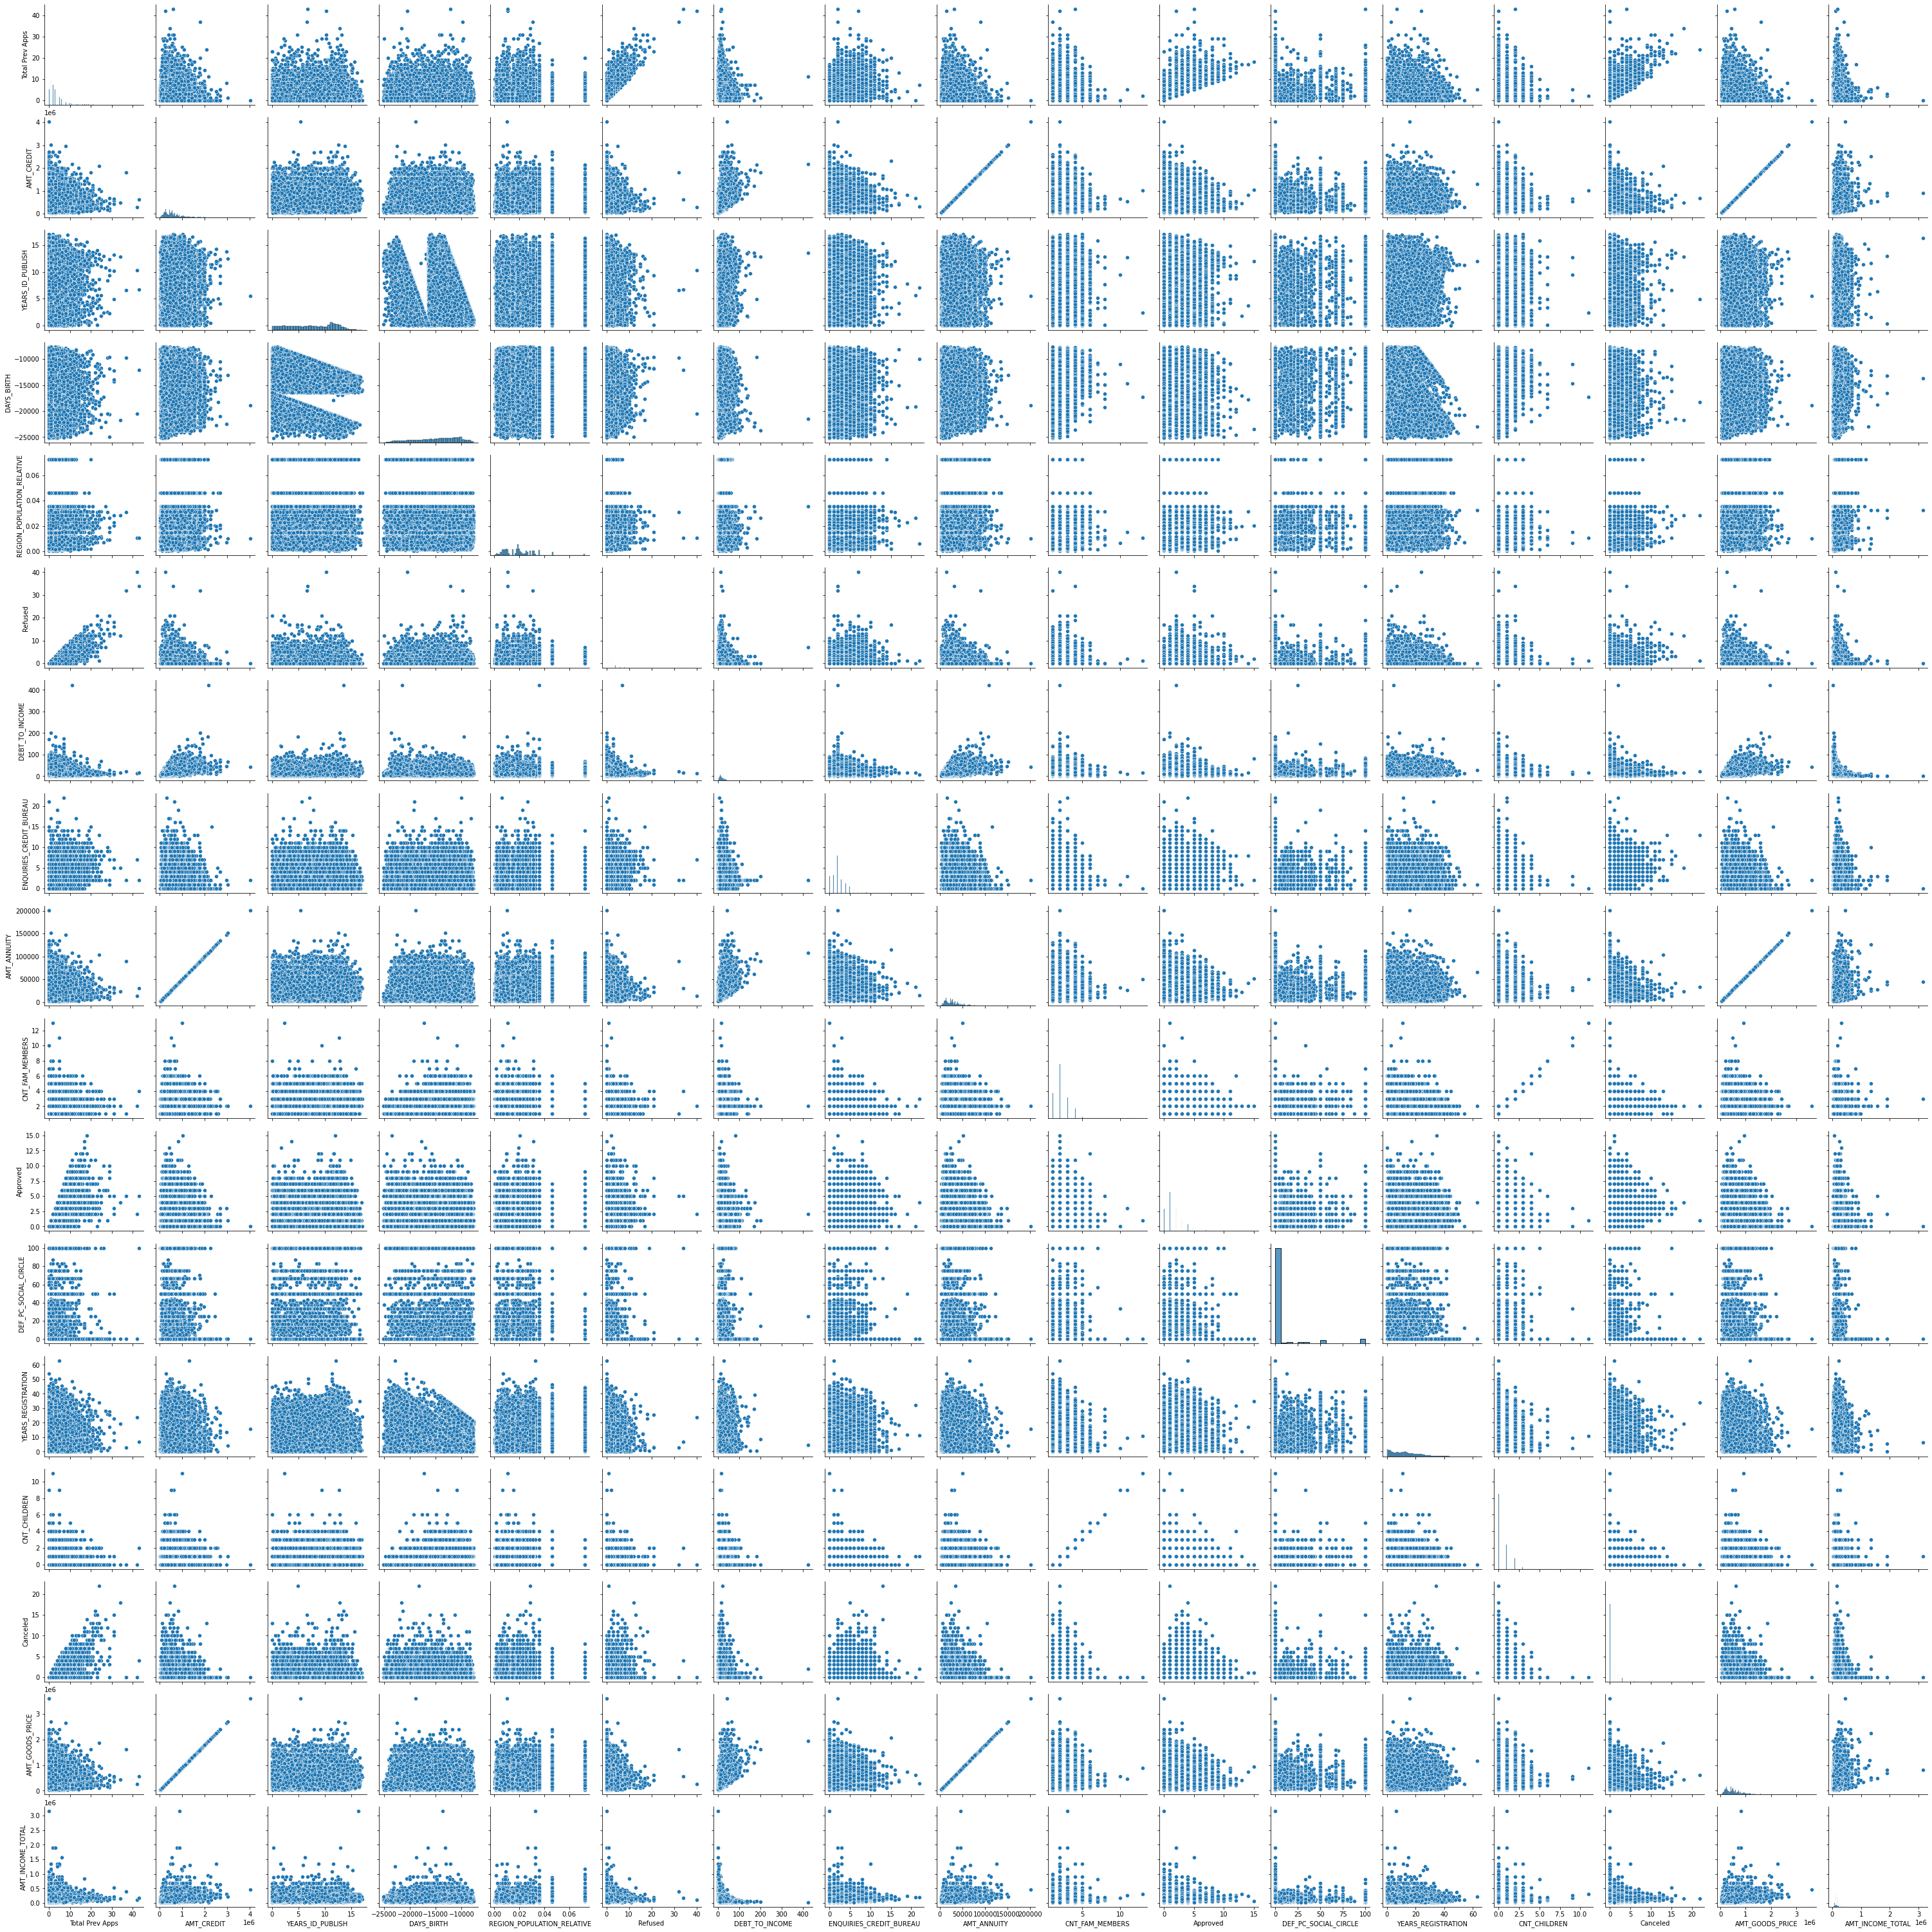

In [110]:
# Create dataframe for TARGET=1 without unnecessary variables and display the correlations
df_1 = df_final[df_final['TARGET']==1][list(set(df_final.columns)-set(['SK_ID_CURR', 'TARGET', 'PrevApps',  'Unused offer']))]
print(df_1.columns, df_1.shape)
print("TOP 10 CORRELATIONS for TARGET=0")
print(getTop10Correlations(df_1))
plt.figure(figsize=(16, 10), dpi=80)
sns.heatmap(df_1.corr(), cmap="Blues", annot=True)
sns.pairplot(data=df_1)

Index(['NAME_FAMILY_STATUS', 'CODE_GENDER', 'Total Prev Apps', 'PA_STATUS',
       'AMT_CREDIT', 'YEARS_ID_PUBLISH', 'DAYS_BIRTH',
       'REGION_POPULATION_RELATIVE', 'Refused', 'DEBT_TO_INCOME',
       'ENQUIRIES_CREDIT_BUREAU', 'AMT_ANNUITY', 'NAME_HOUSING_TYPE',
       'CNT_FAM_MEMBERS', 'Approved', 'REGION_RATING_CLIENT_W_CITY',
       'DEF_PC_SOCIAL_CIRCLE', 'YEARS_REGISTRATION', 'CNT_CHILDREN',
       'Canceled', 'AGE', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL'],
      dtype='object') (282679, 23)
TOP 10 CORRELATIONS for TARGET=0
          Variable1        Variable2  CORR
0        AMT_CREDIT  AMT_GOODS_PRICE  1.00
19      AMT_ANNUITY       AMT_CREDIT  1.00
21  AMT_GOODS_PRICE      AMT_ANNUITY  1.00
23  CNT_FAM_MEMBERS     CNT_CHILDREN  0.88
25         Approved  Total Prev Apps  0.77
27  Total Prev Apps          Refused  0.68
29  Total Prev Apps         Canceled  0.66
31   DEBT_TO_INCOME       AMT_CREDIT  0.65
33   DEBT_TO_INCOME  AMT_GOODS_PRICE  0.65
35   DEBT_TO_INCOME      AMT_AN

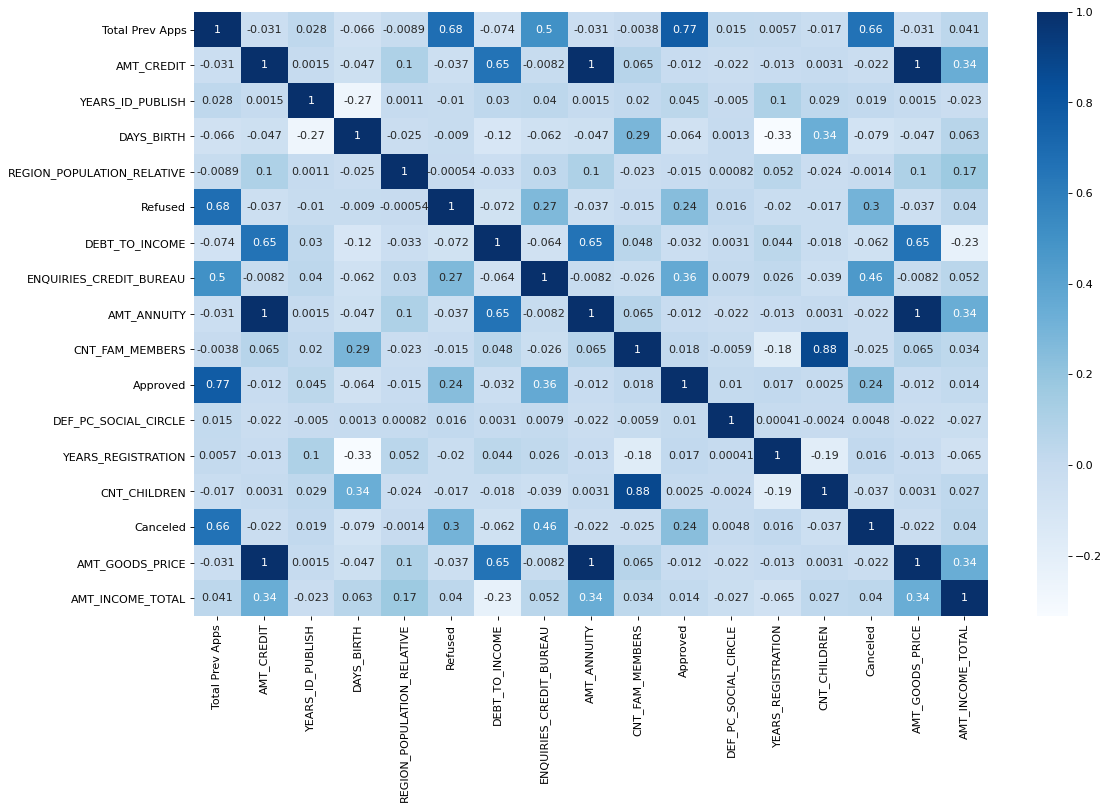

In [111]:
# Create dataframe for TARGET=0 without unnecessary variables and display the correlations
df_0 = df_final[df_final['TARGET']==0][list(set(df_final.columns)-set(['SK_ID_CURR', 'TARGET', 'PrevApps',  'Unused offer', ]))]
print(df_0.columns, df_0.shape)
print("TOP 10 CORRELATIONS for TARGET=0")
print(getTop10Correlations(df_0))
plt.figure(figsize=(16, 10), dpi=80)
sns.heatmap(df_0.corr(), cmap="Blues", annot=True)
sns.pairplot(data=df_0)

## **RECOMMENDATIONS**

| DRIVING FACTOR | Description | Risky | Safe |
|---|---|---|---|
| GENDER | More percentage of male clients have difficulties in paying | Male Clients | Female clients|
| AGE | Lesser age, more difficulty in paying | Younger Clients | Older clients|
| CHILDREN | With increase in number of kids, the ability to pay decreases.| More children | Less children |
| FAMILY MEMBERS | With increase in number of family members, the ability to pay decreases | Larger family size | Smaller family size |
| EDUCATION | With increase in education, the ability to pay increases | Clients with lesser education | Clients with higher education |
| HOUSING TYPE | Clients in Rented apartment or staying at parents house have difficulties in paying off | | |
| REGION | Higher the region, the clients find it more difficult to pay. Clients from regions 3 have difficulty in paying off | Higher Region category | Lower Region category |
| DEFAULTERS IN SOCIAL CIRCLE | | Higher percentage of defaulters in social circle | Lower %age of defaulters in social circle |
| | | | |
| | | | |

Safe bet: Older female applicants with no children and small family size
Risky proposition: Younger male 

Majority of the clients are in
- HOUSING_TYPE- House/Apartment
- NAME_FAMILY_STATUS - Married
- CNT_FAM_MEMBERS = 2
- CNT_CHILDREN = 0
- Age: 30-40
- Female 
- REGION_RATING_CLIENT = 
- Who apply around midnight.